# 批量华为手表睡眠分期

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import json
import os
import re

In [2]:
# 设置中文字体属性
font_path = '../data/SimHei.ttf'
prop = FontProperties(fname=font_path, size=16)

In [3]:
# 将时间戳转换为日期时间
def transfer(timestamp):
    return datetime.fromtimestamp(timestamp / 1000000000)

In [4]:
# 读取JSON文件并提取数据
def read_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [5]:
# 提取睡眠数据
def extract_sleep_data(data):
    sample_points = data["healthRecords"][0]["subData"]['com.huawei.continuous.sleep.fragment']['samplePoints']
    sleep_data = data["healthRecords"][0]["value"]
    return sample_points, sleep_data

In [6]:
# 处理样本点以提取时间和阶段
def process_sample_points(sample_points):
    times = []
    stages = []
    for point in sample_points:
        time = point["startTime"]
        date_time = datetime.fromtimestamp(time / 1000000000)
        times.append(date_time)
        stage = point["value"][0]["integerValue"]
        stages.append(stage)
    return times, stages

In [7]:
# 将阶段映射到颜色
def map_stages(stages):
    return [2 if x == 1 else 3 if x == 2 else 1 if x == 3 else 4 for x in stages]

In [8]:
# 计算每个睡眠阶段的时长
def calculate_stage_durations(stage_values):
    light_sleep_time = stage_values.count(1)
    rem_sleep_time = stage_values.count(2)
    deep_sleep_time = stage_values.count(3)
    awake_time = stage_values.count(4)
    return light_sleep_time, rem_sleep_time, deep_sleep_time, awake_time

In [9]:
# 将分钟转换为小时和分钟
def hm(total_minutes):
    hours = total_minutes // 60
    minutes = total_minutes % 60
    return hours, minutes

In [10]:
# 作图
def plot_sleep_stages(times, stage_values, total_sleep_duration, deep_sleep_duration, light_sleep_time, rem_sleep_time, awake_time,figpath):
    colors = ['purple', 'r', 'pink', 'y']
    plt.figure(figsize=(20, 7))
    current_stage = stage_values[0]
    start_idx = 0

    for i in range(1, len(stage_values)):
        if stage_values[i] != current_stage:
            plt.plot(range(start_idx, i), stage_values[start_idx:i], color=colors[current_stage-1])
            plt.fill_between(range(start_idx, i), [current_stage - 1] * (i - start_idx), [current_stage] * (i - start_idx), color=colors[current_stage - 1], step="pre")
            start_idx = i
            current_stage = stage_values[i]

    plt.plot(range(start_idx, len(stage_values)), stage_values[start_idx:], color=colors[current_stage-1])
    plt.fill_between(range(start_idx, len(stage_values)), [current_stage - 1] * (len(stage_values) - start_idx), [current_stage] * (len(stage_values) - start_idx), color=colors[current_stage - 1], step="pre")

    h, m = hm(total_sleep_duration)
    q = str(figpath)[-10:-4]
    q = q.strip("/")

    plt.title(f'{q}华为手表睡眠分期结果\n 总睡眠时间：{h}小时{m}分钟 深睡时间：{deep_sleep_duration}min 浅睡时间：{light_sleep_time}min  快速眼动时间：{rem_sleep_time}min    清醒时间：{awake_time}min', fontproperties=prop)
    plt.xlabel('时间', fontproperties=prop)
    plt.ylabel('阶段', fontproperties=prop)
    plt.yticks([1, 2, 3, 4], ['深睡', '浅睡', '快速眼动', '清醒'], fontproperties=prop)
    plt.xticks([0, len(stage_values)], [times[0], times[-1]], rotation=5, ha='right', va='top', fontproperties=prop)
    plt.savefig(figpath)

In [11]:
def main(file_path,figpath):
    data = read_data(file_path)
    sample_points, sleep_data = extract_sleep_data(data)
    times, stages = process_sample_points(sample_points)
    stage_values = map_stages(stages)
    light_sleep_time, rem_sleep_time, deep_sleep_time, awake_time = calculate_stage_durations(stage_values)
    total_sleep_duration = sleep_data[6]["integerValue"]  # 总睡眠时长
    plot_sleep_stages(times, stage_values, total_sleep_duration, deep_sleep_time, light_sleep_time, rem_sleep_time, awake_time,figpath)


/tmp/ipykernel_8900/1221449924.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 7))


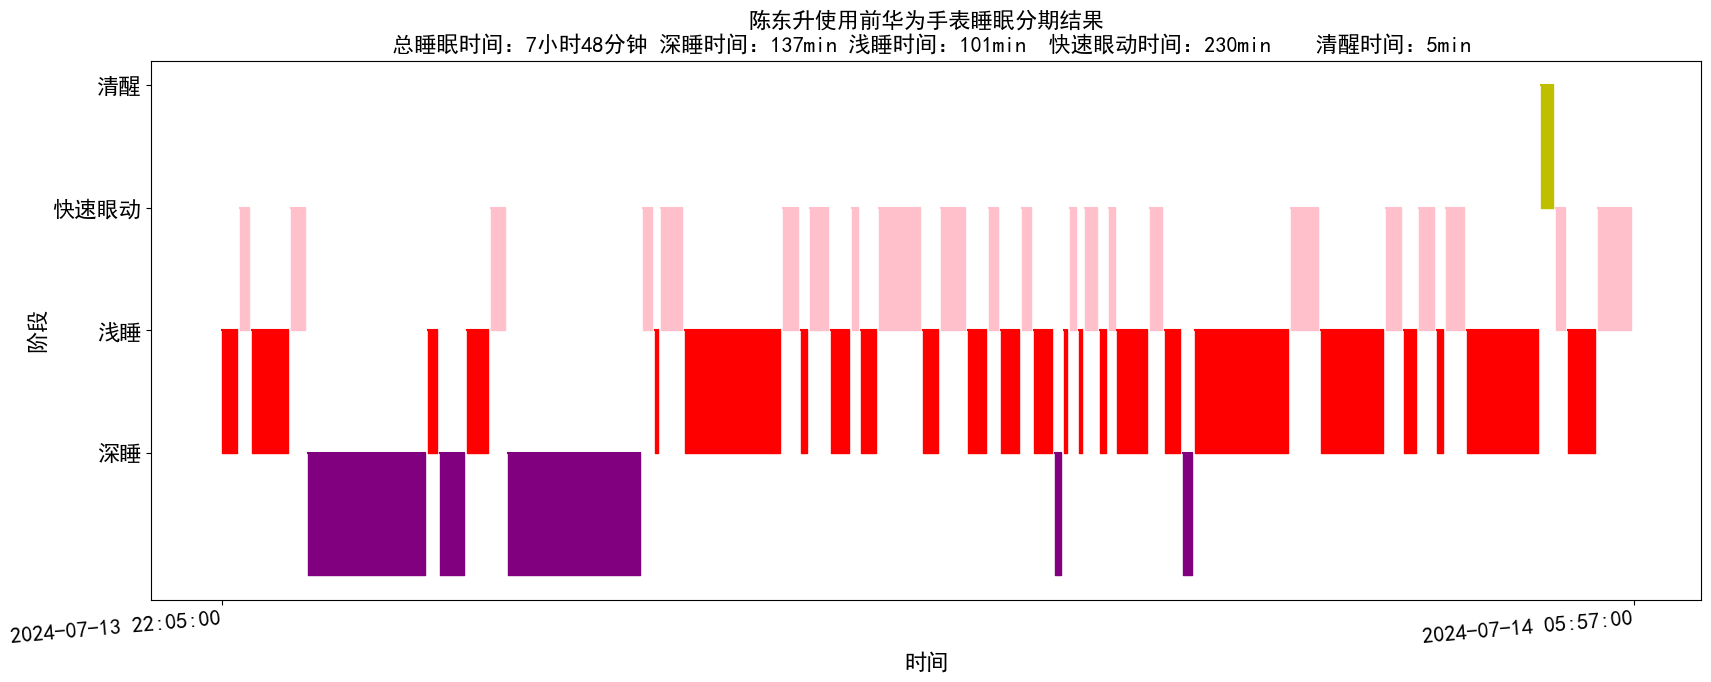

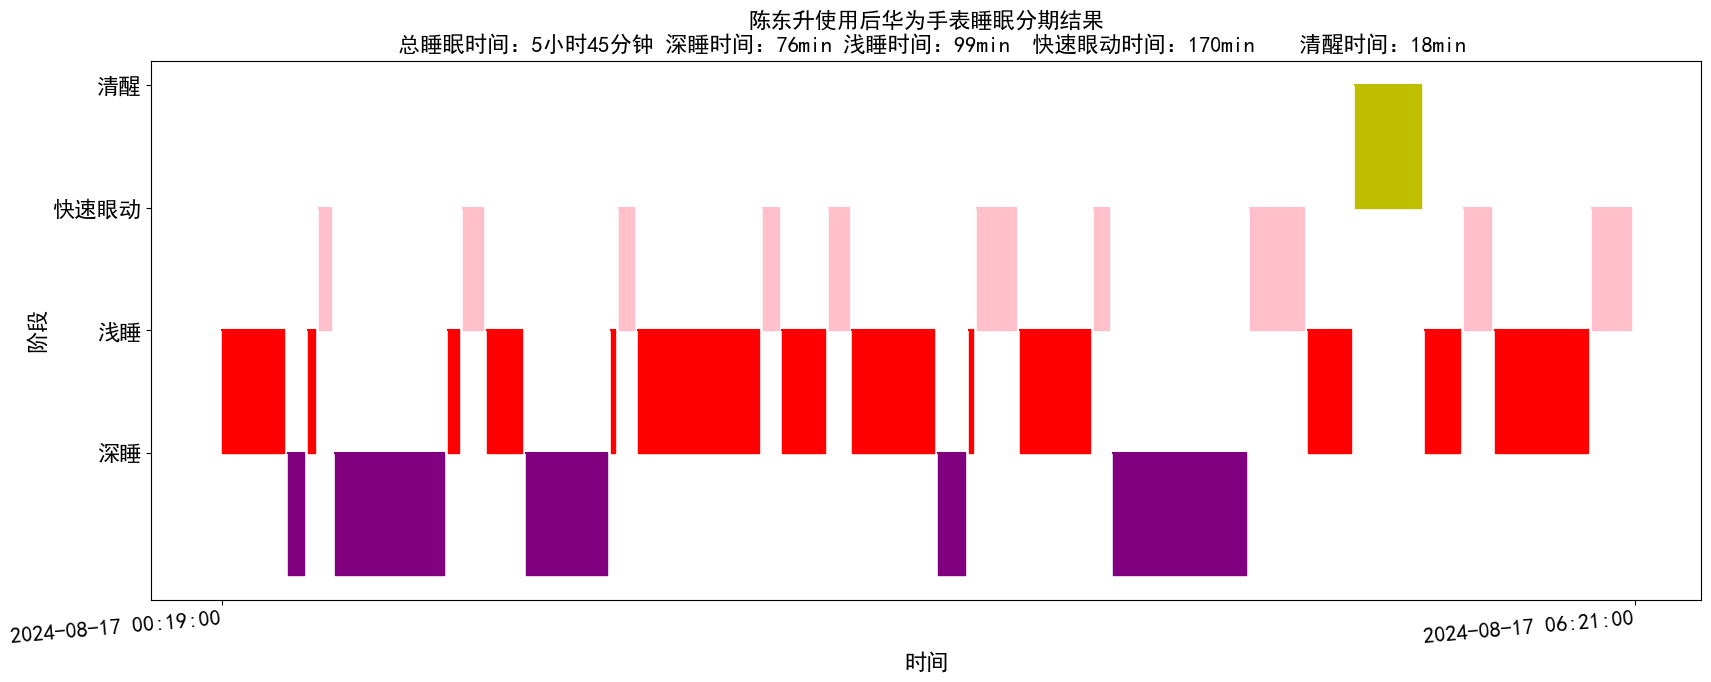

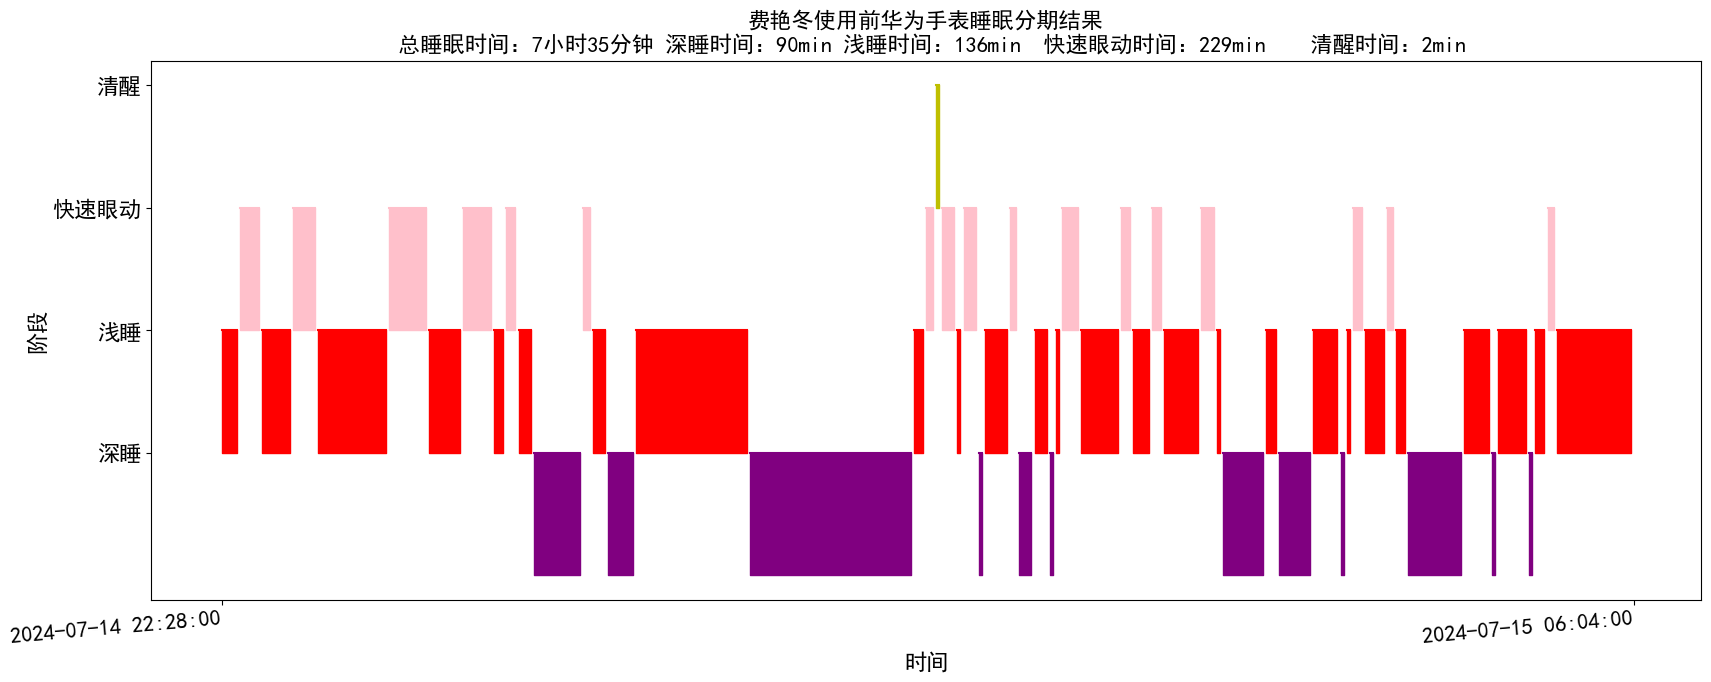

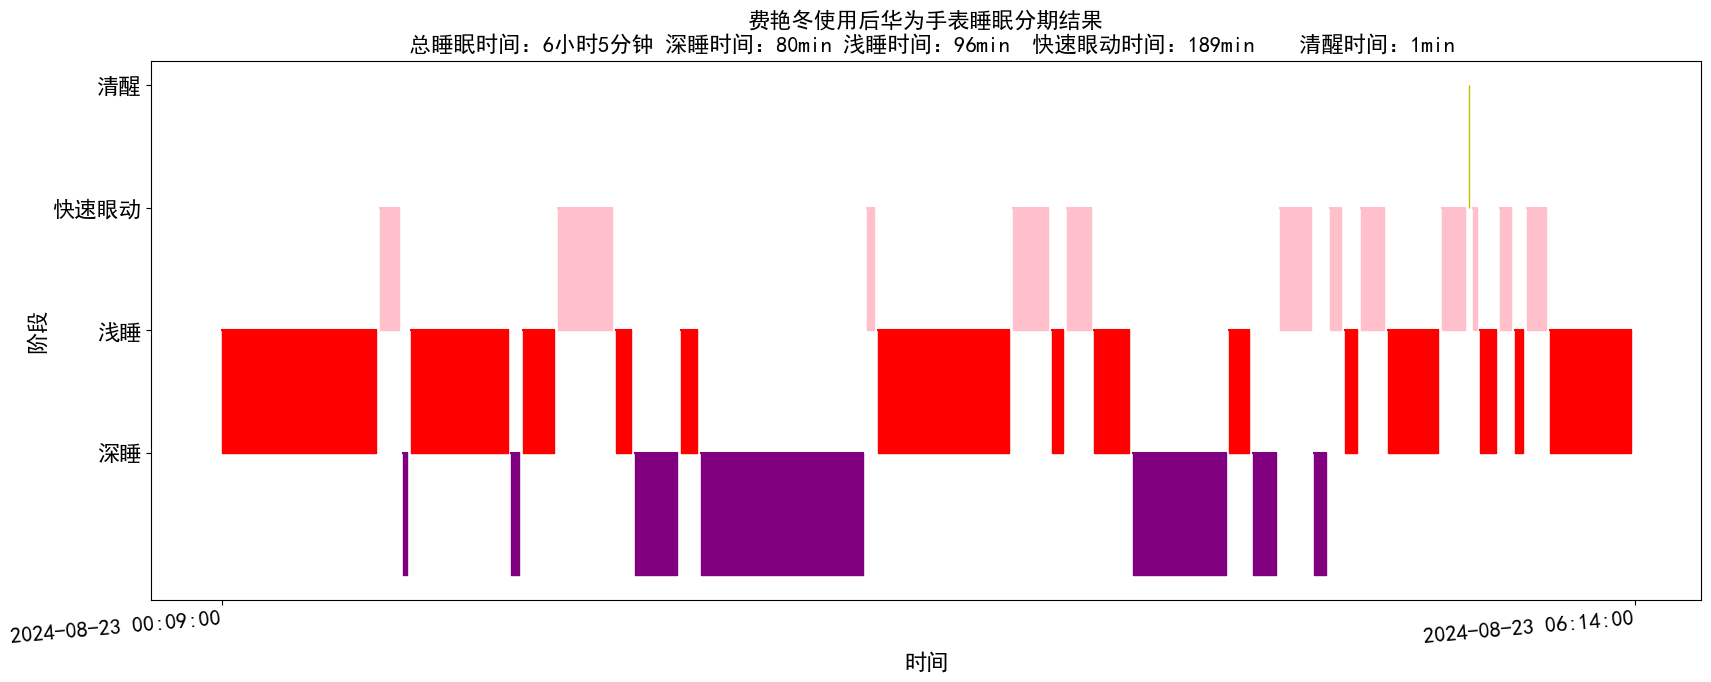

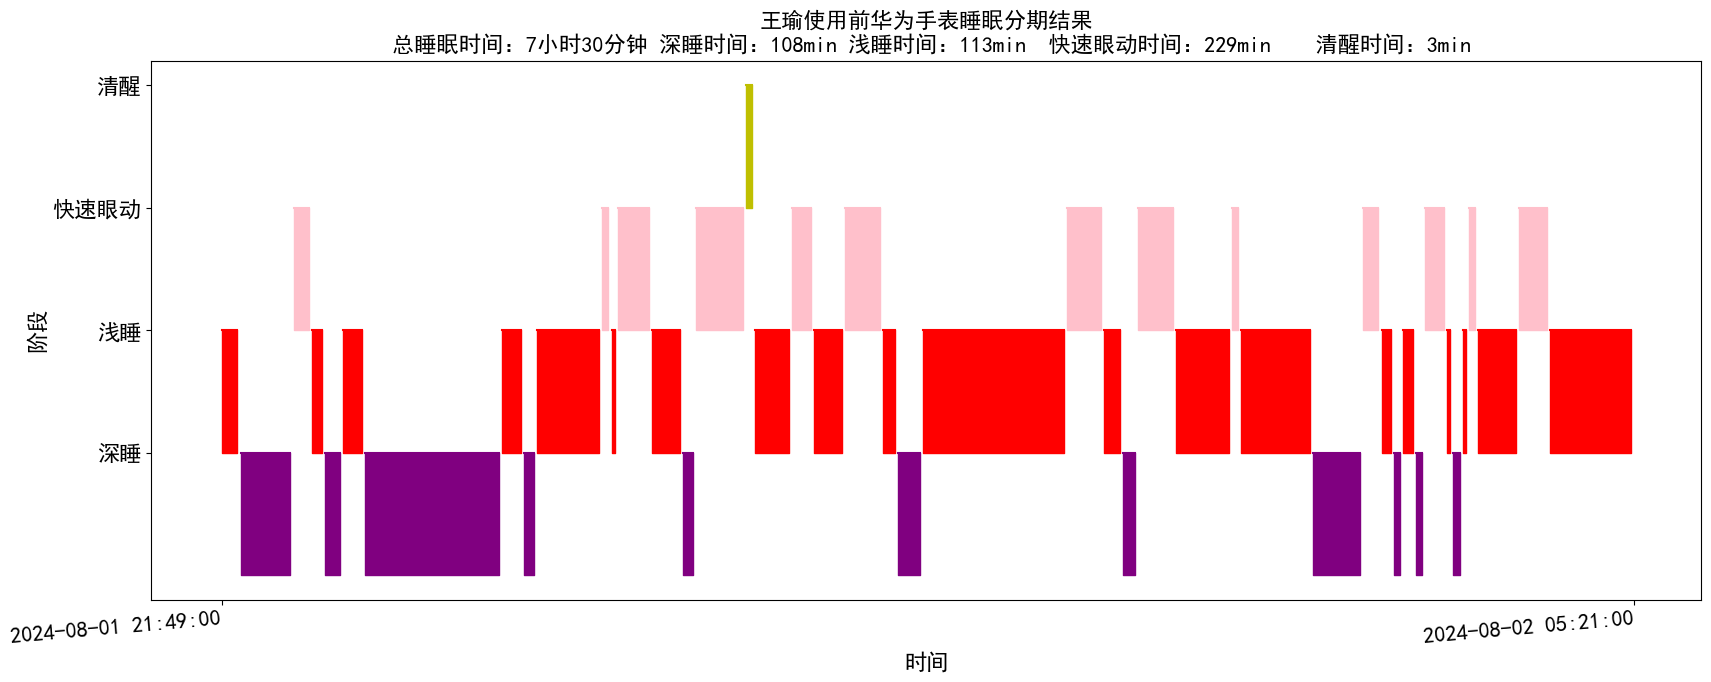

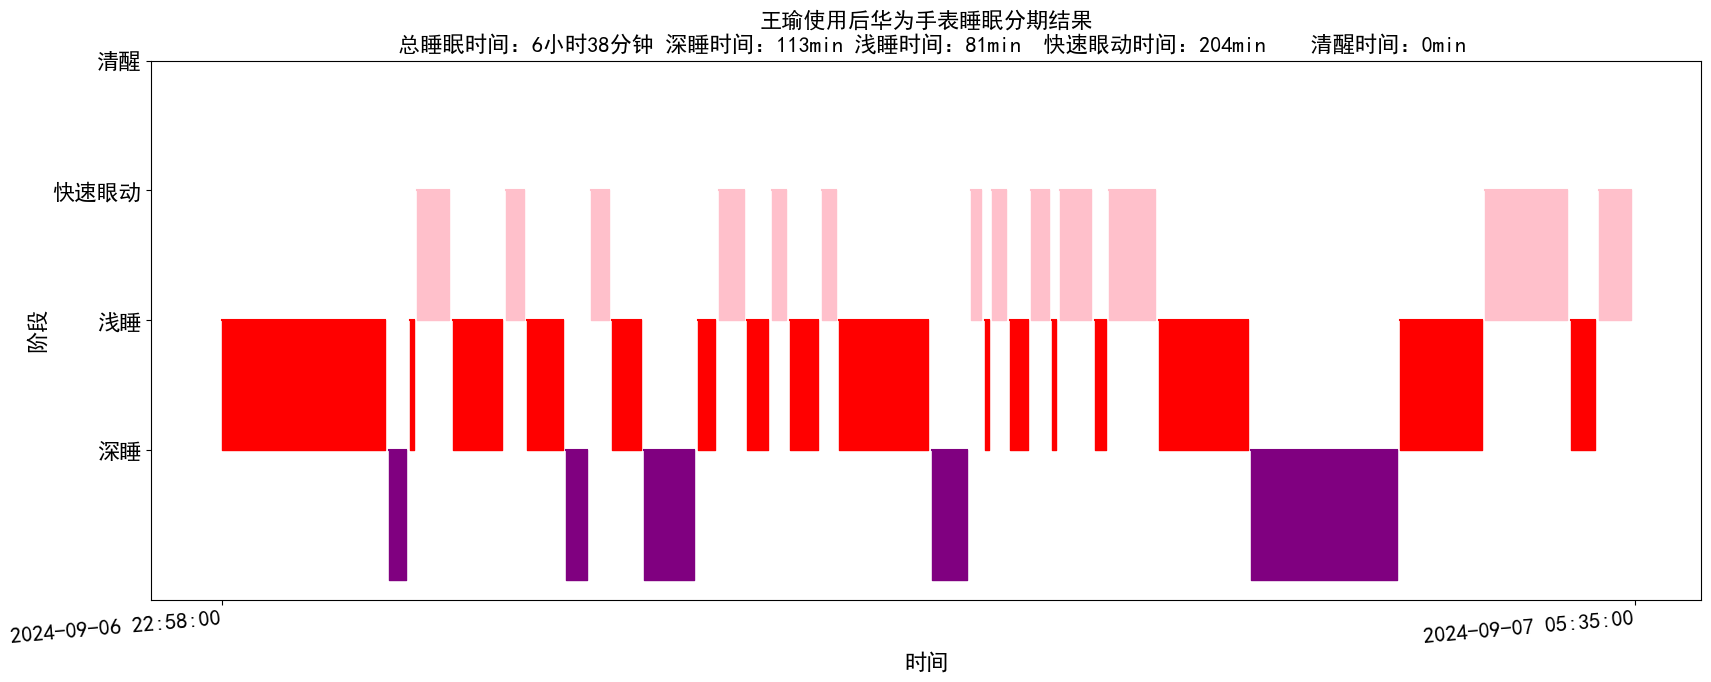

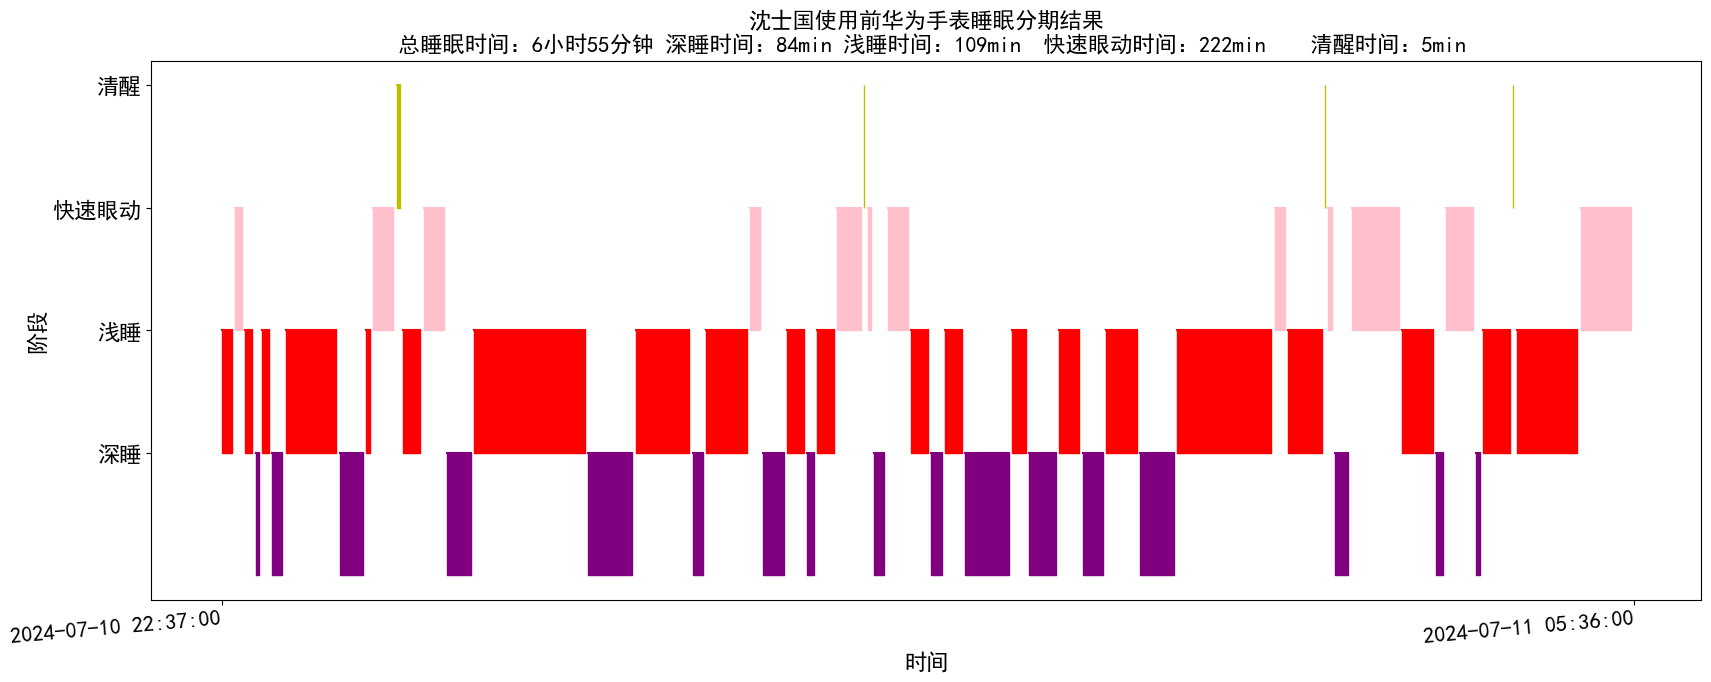

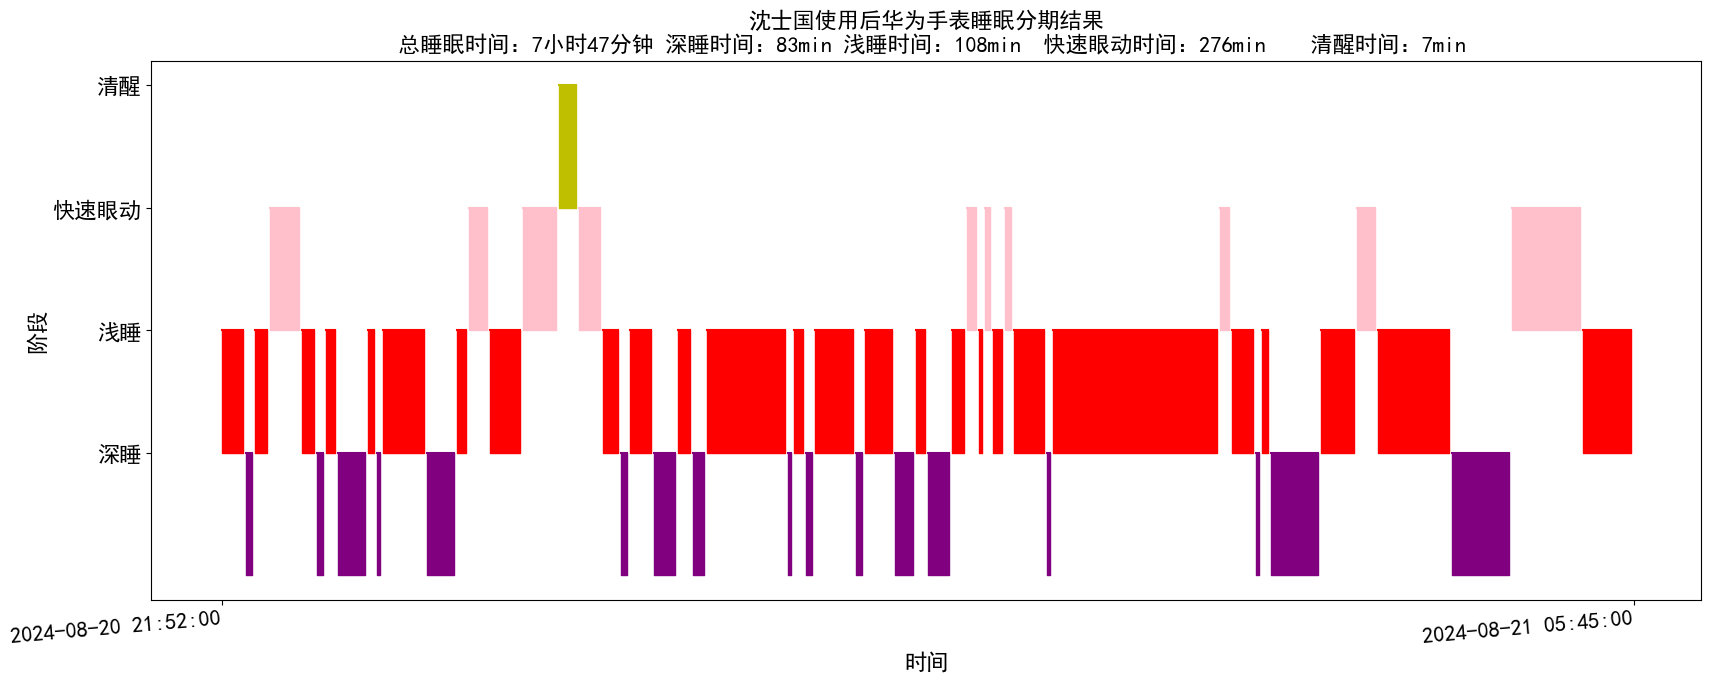

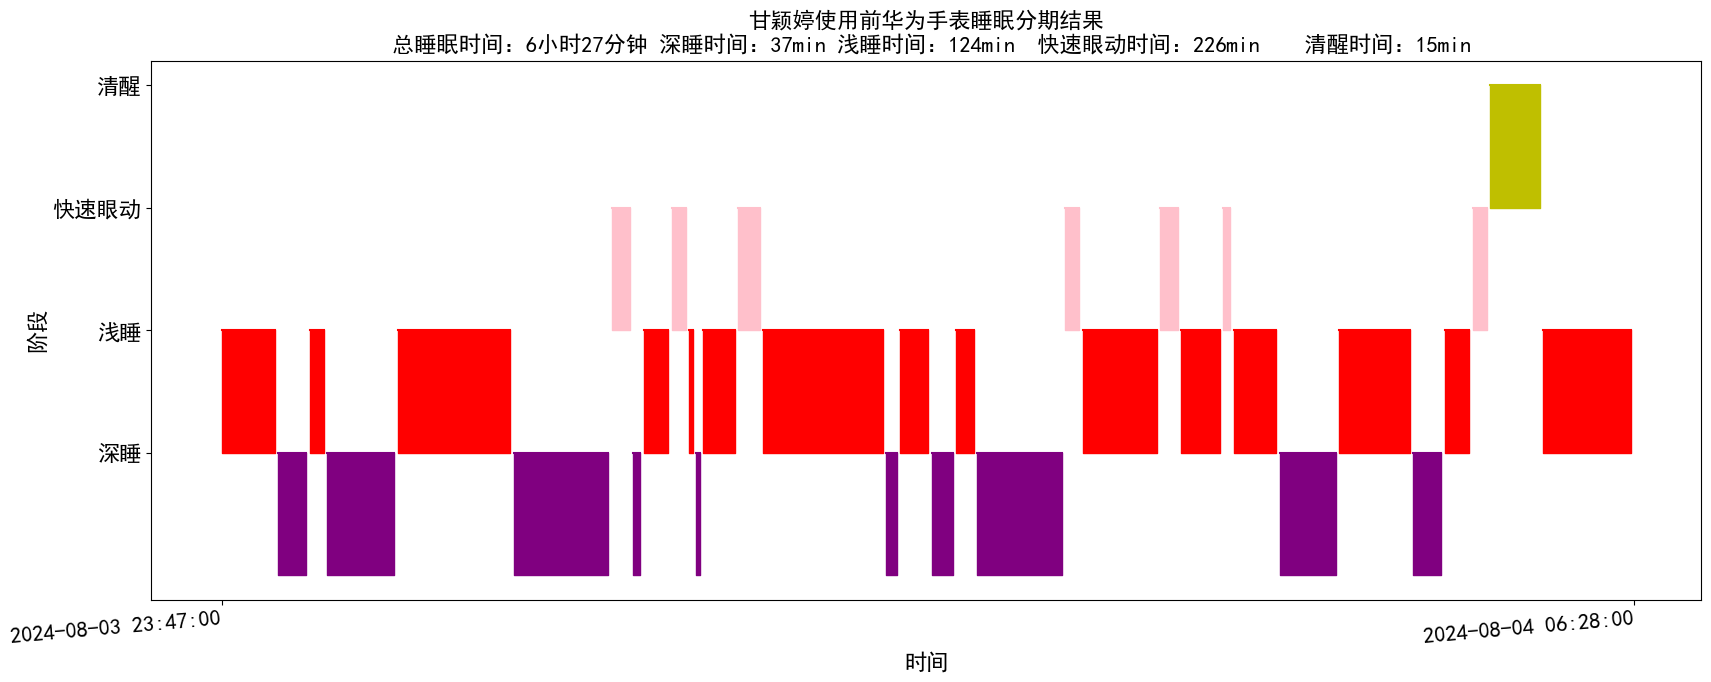

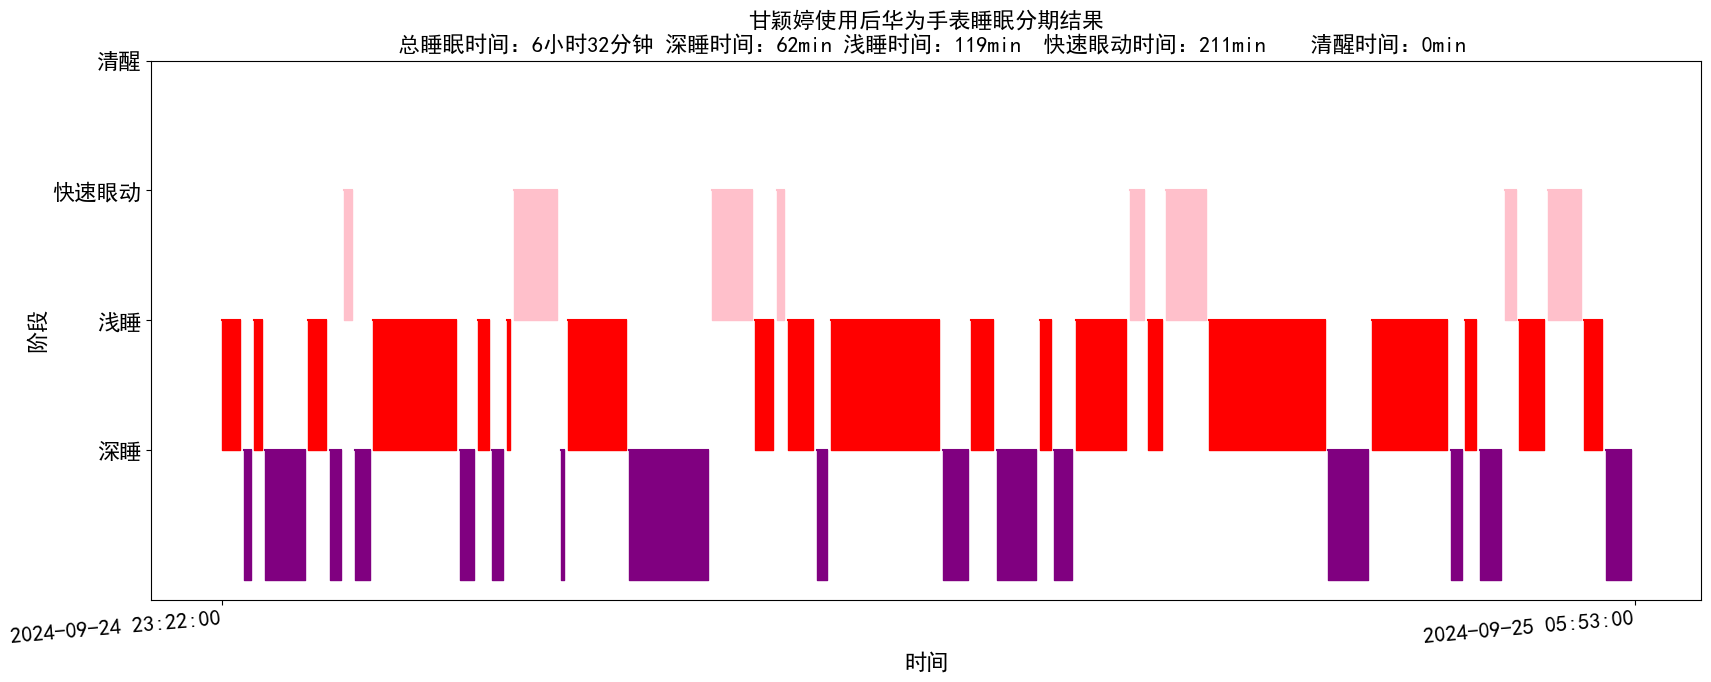

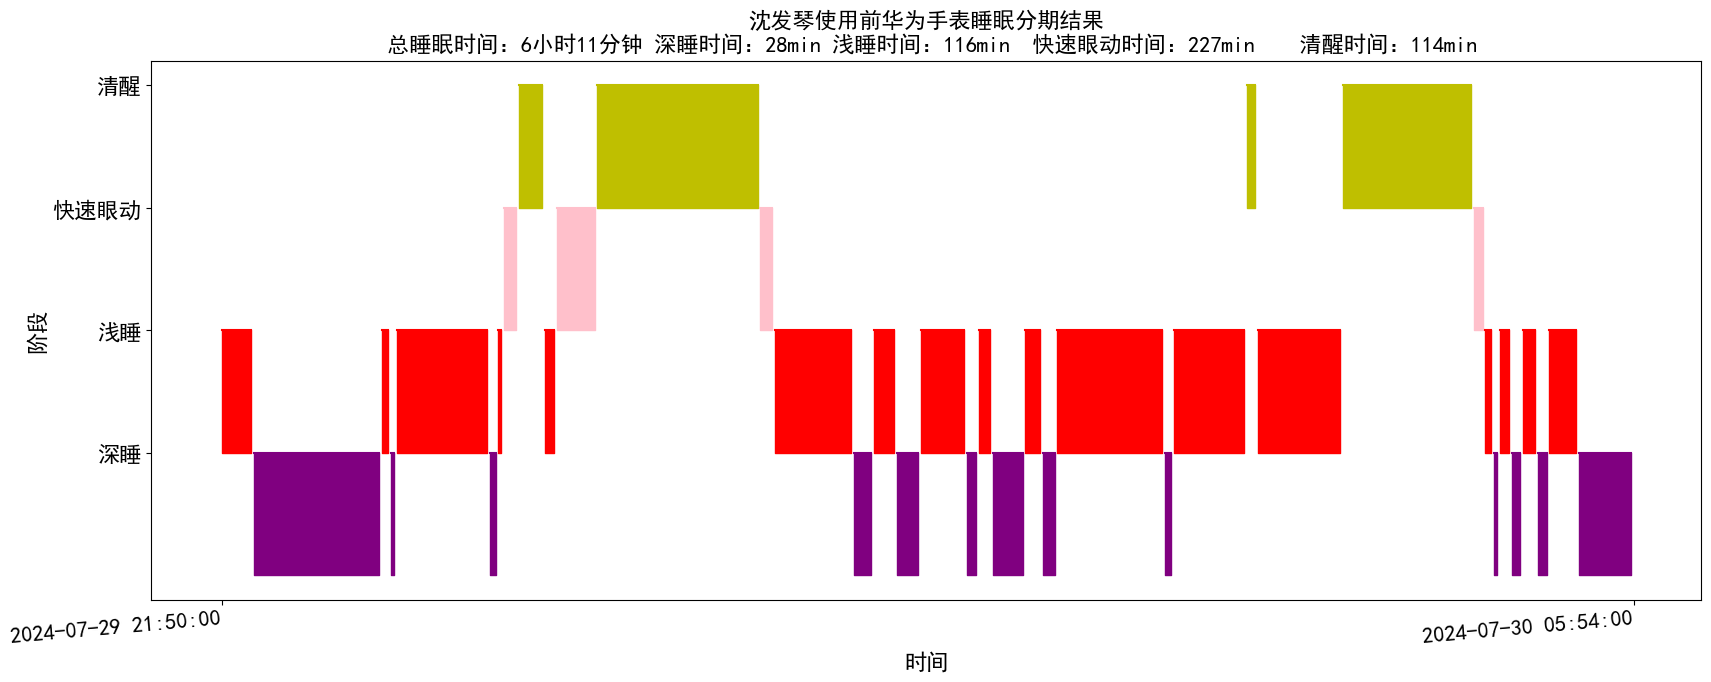

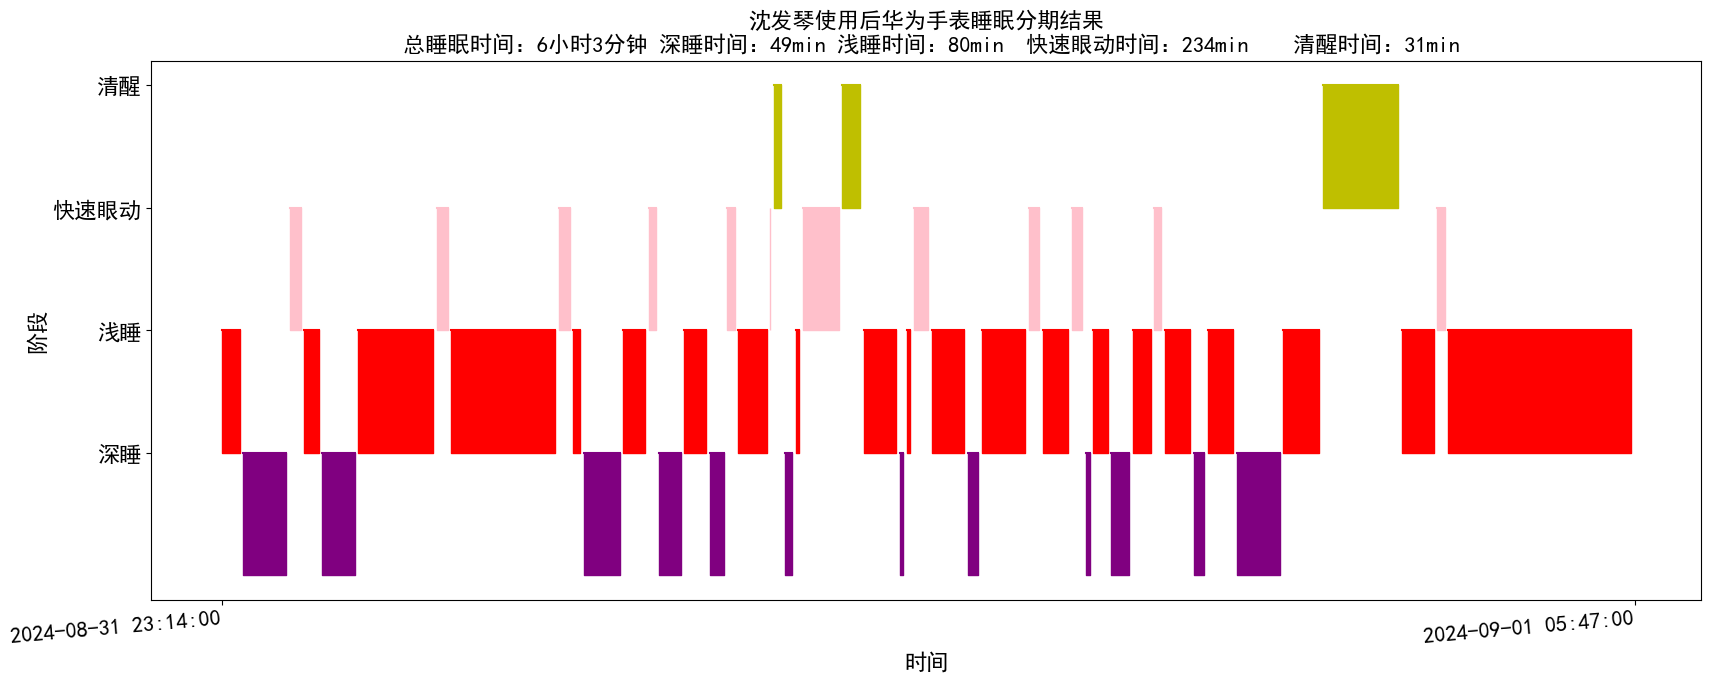

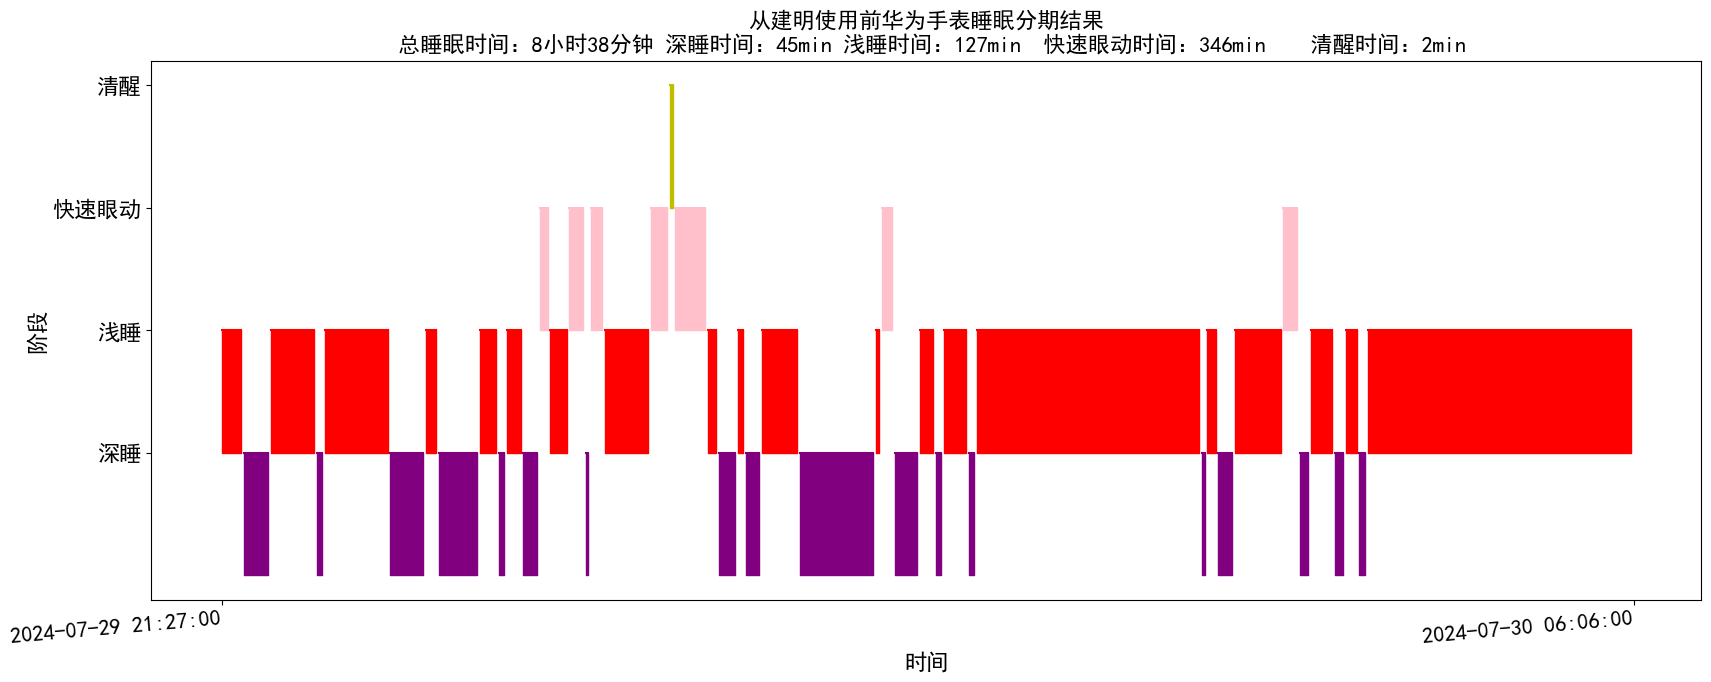

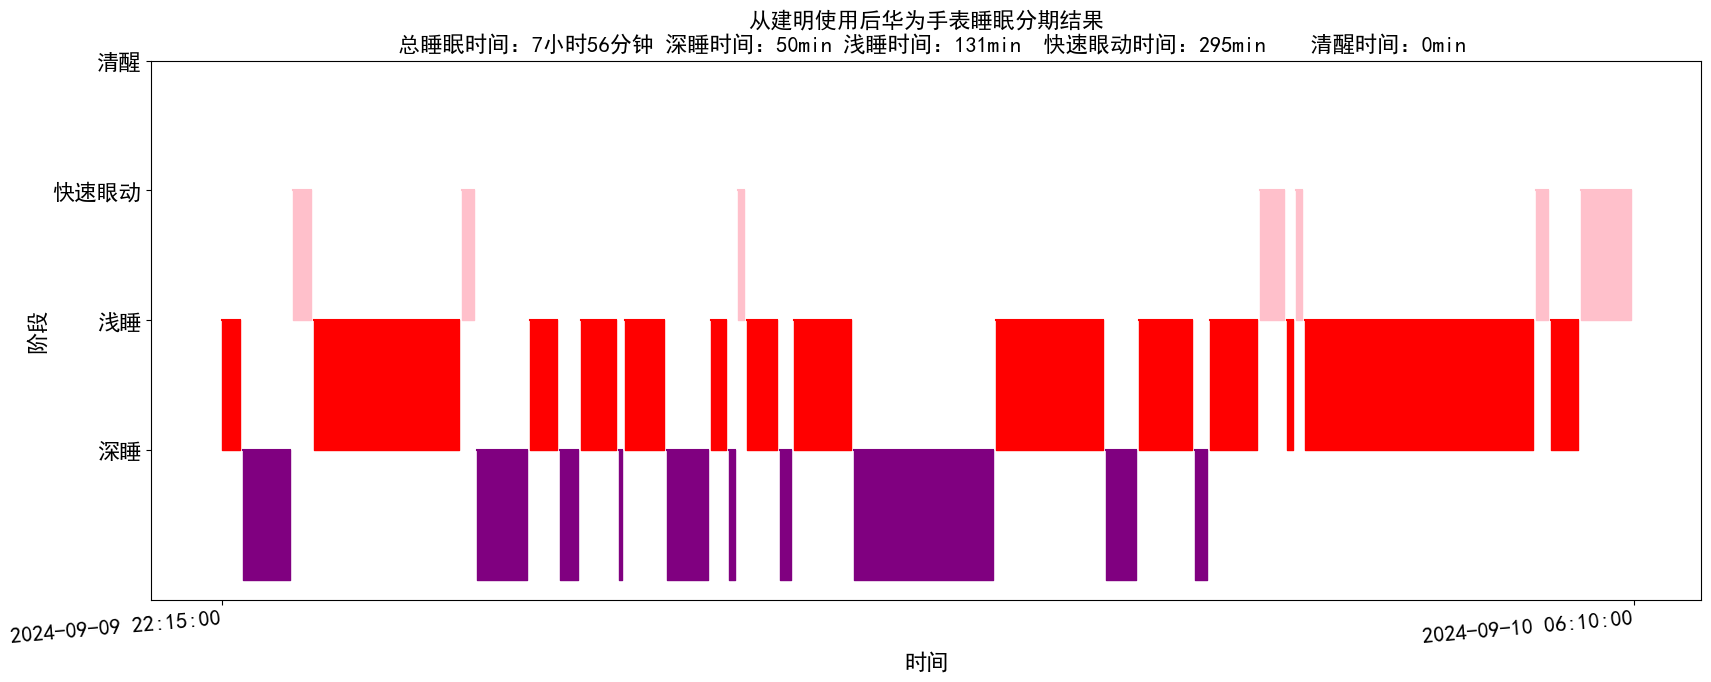

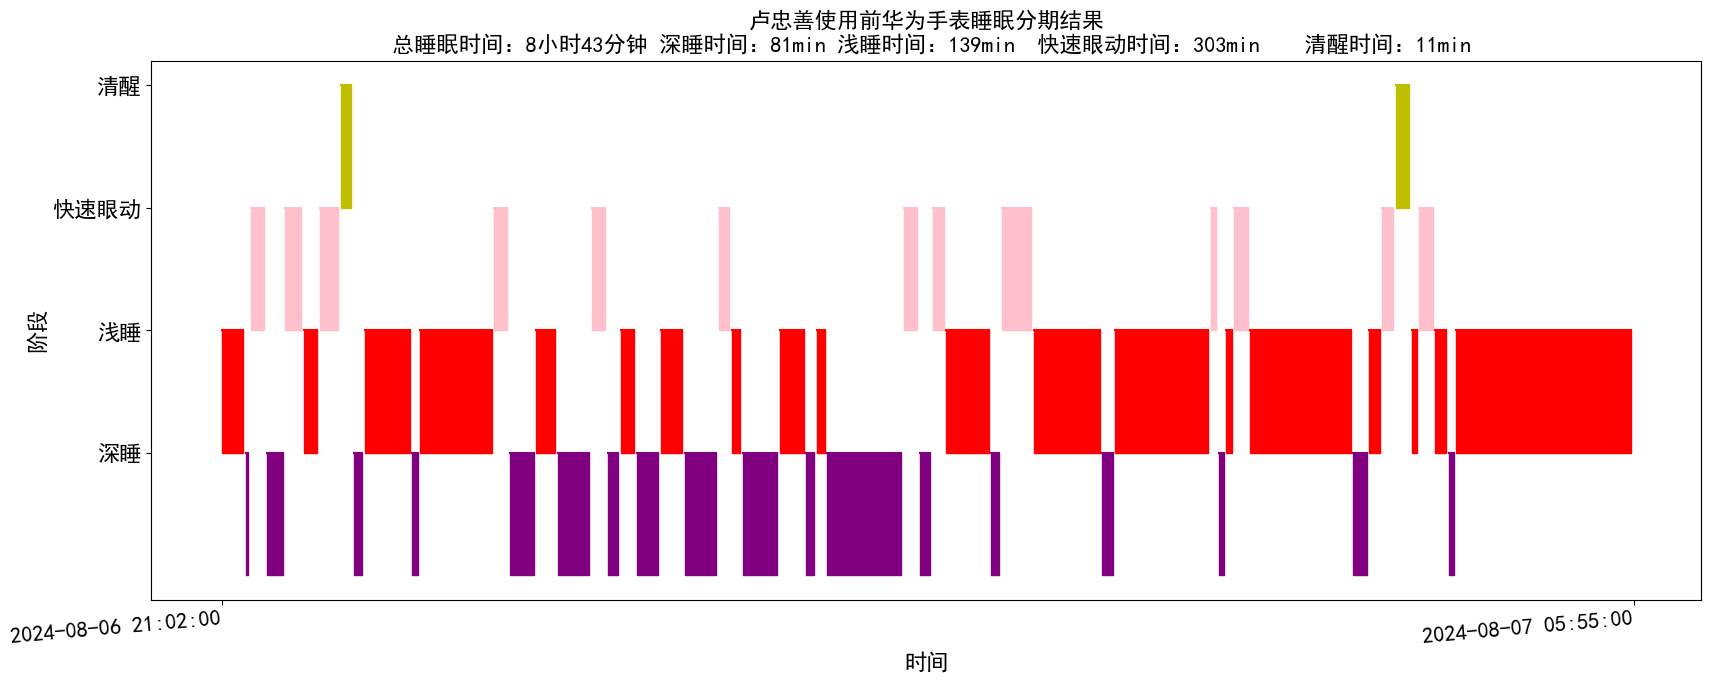

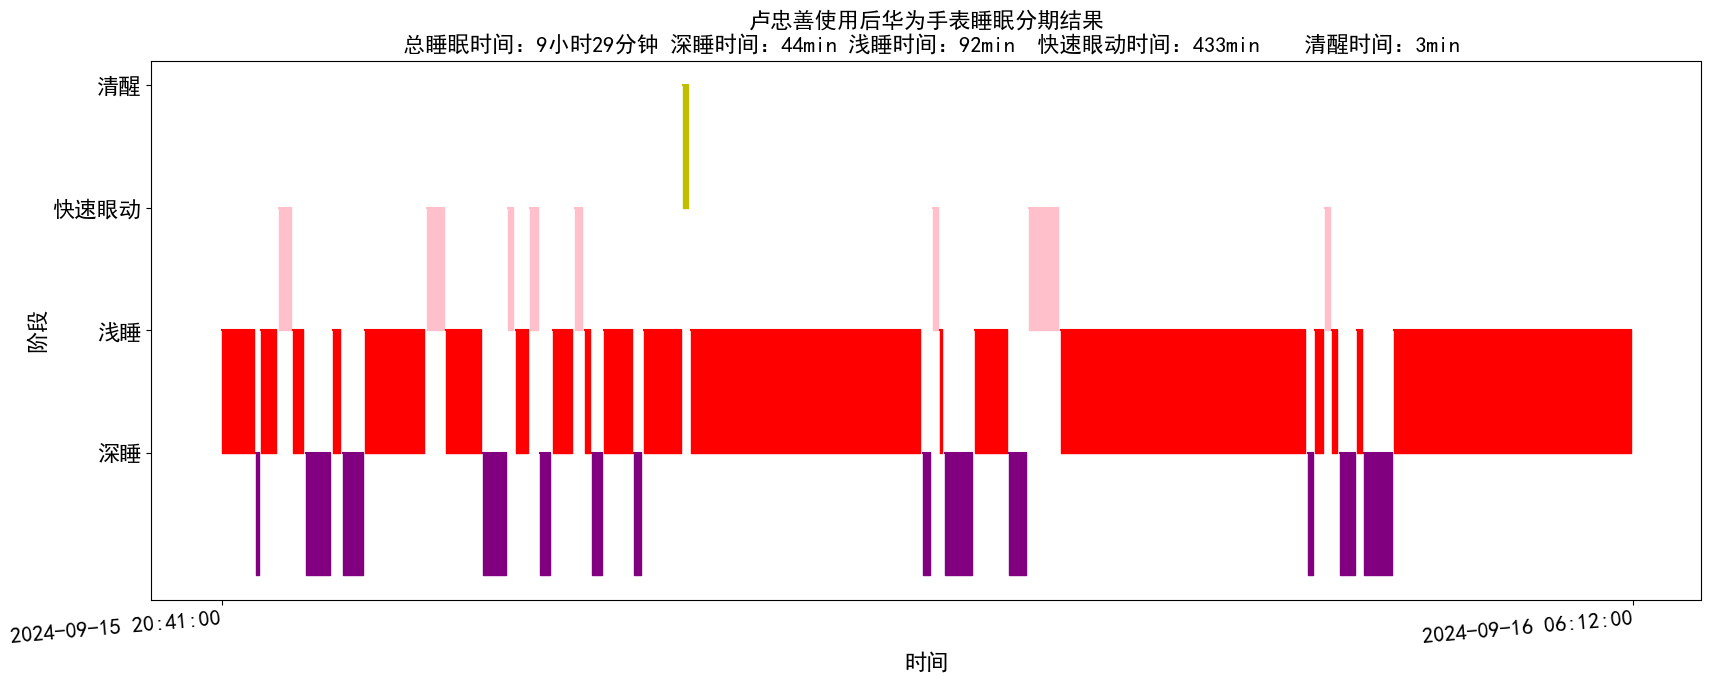

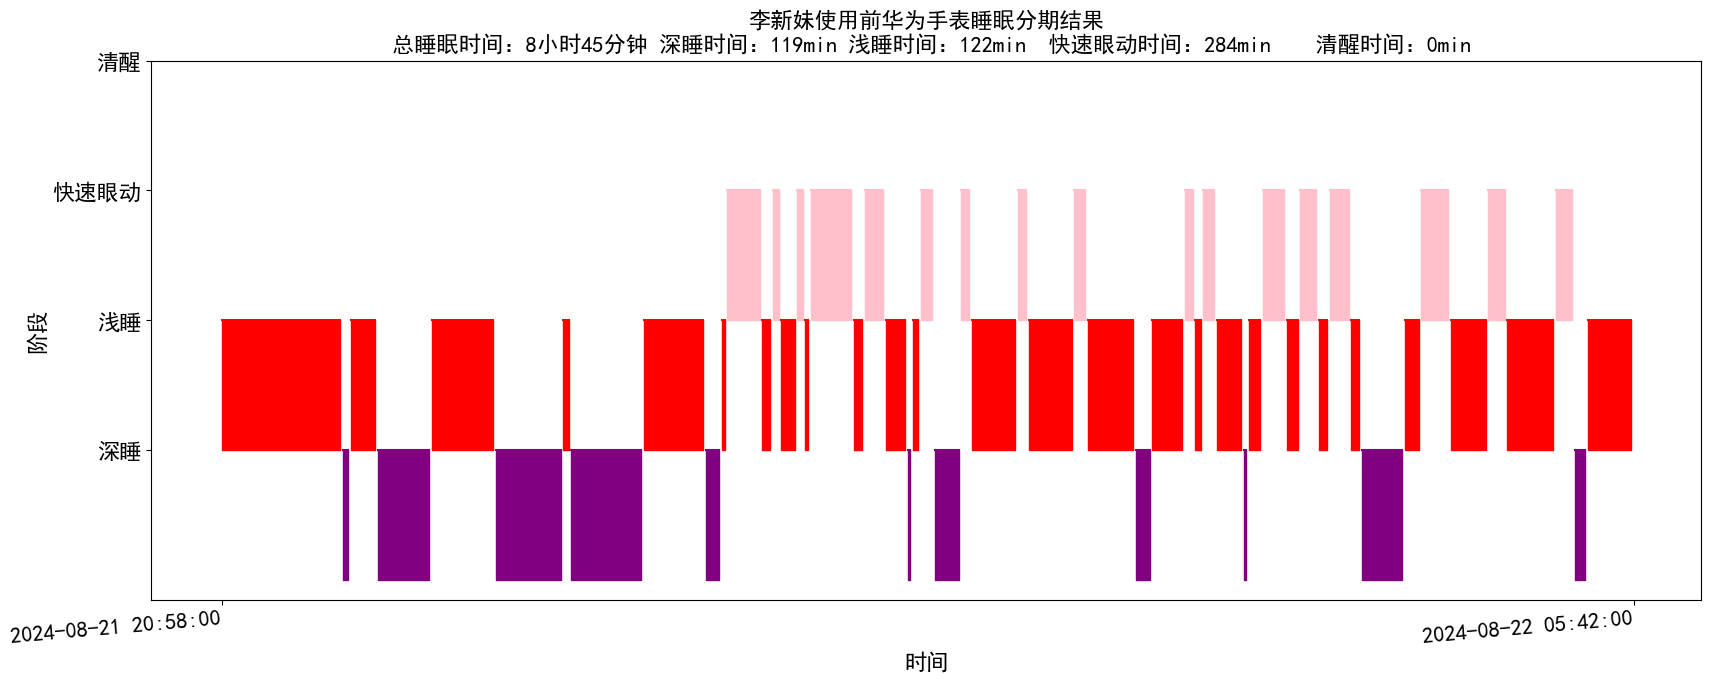

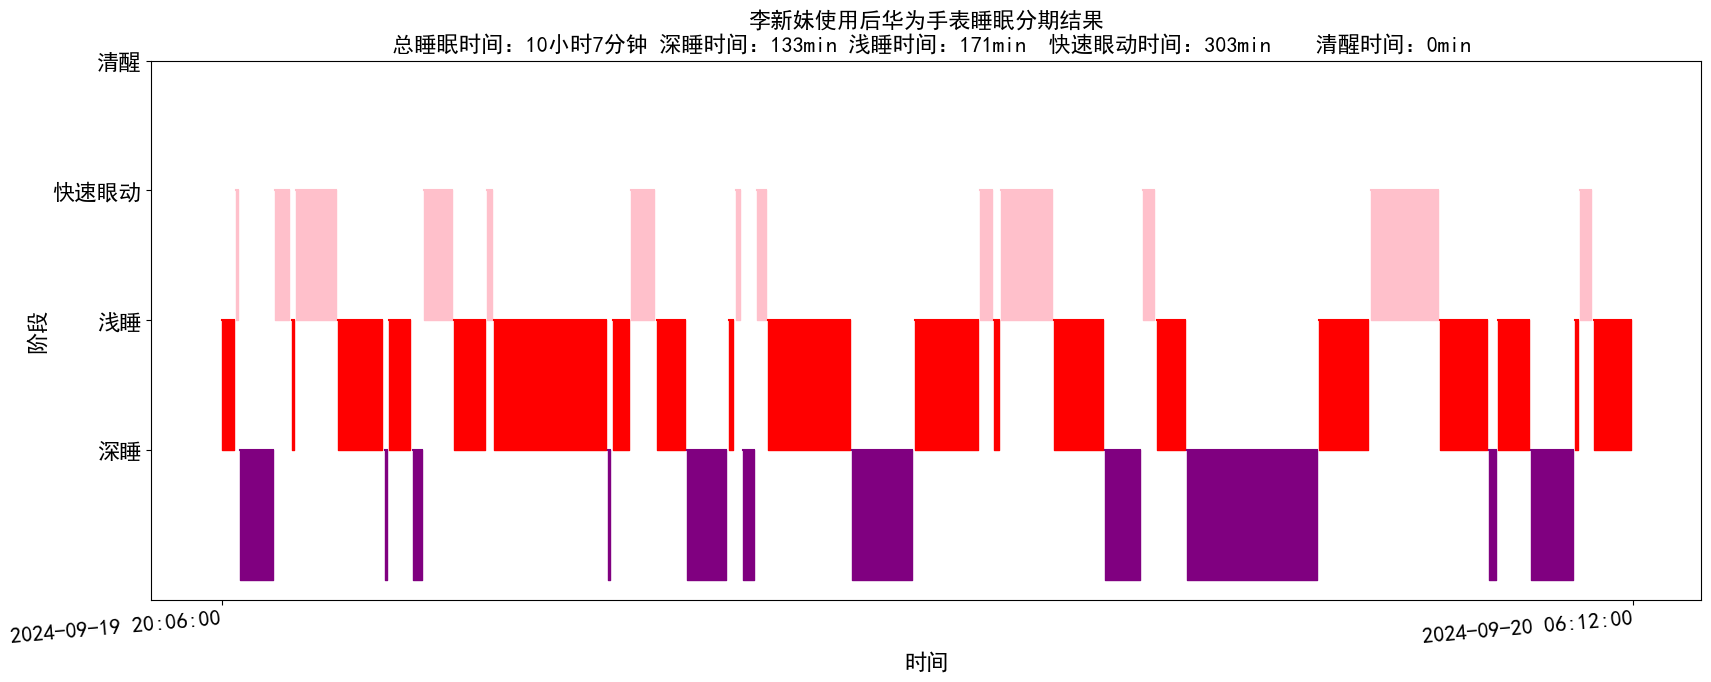

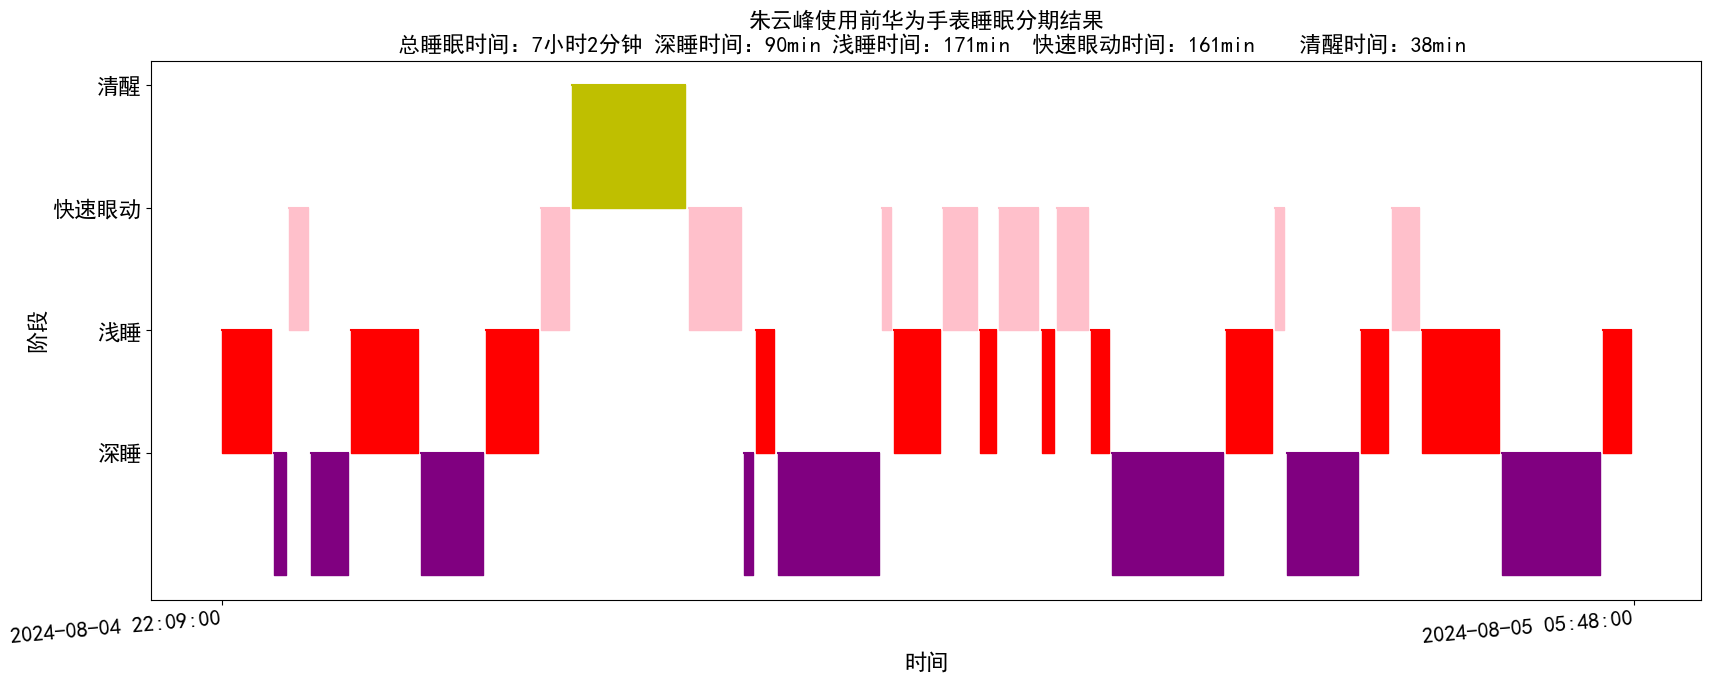

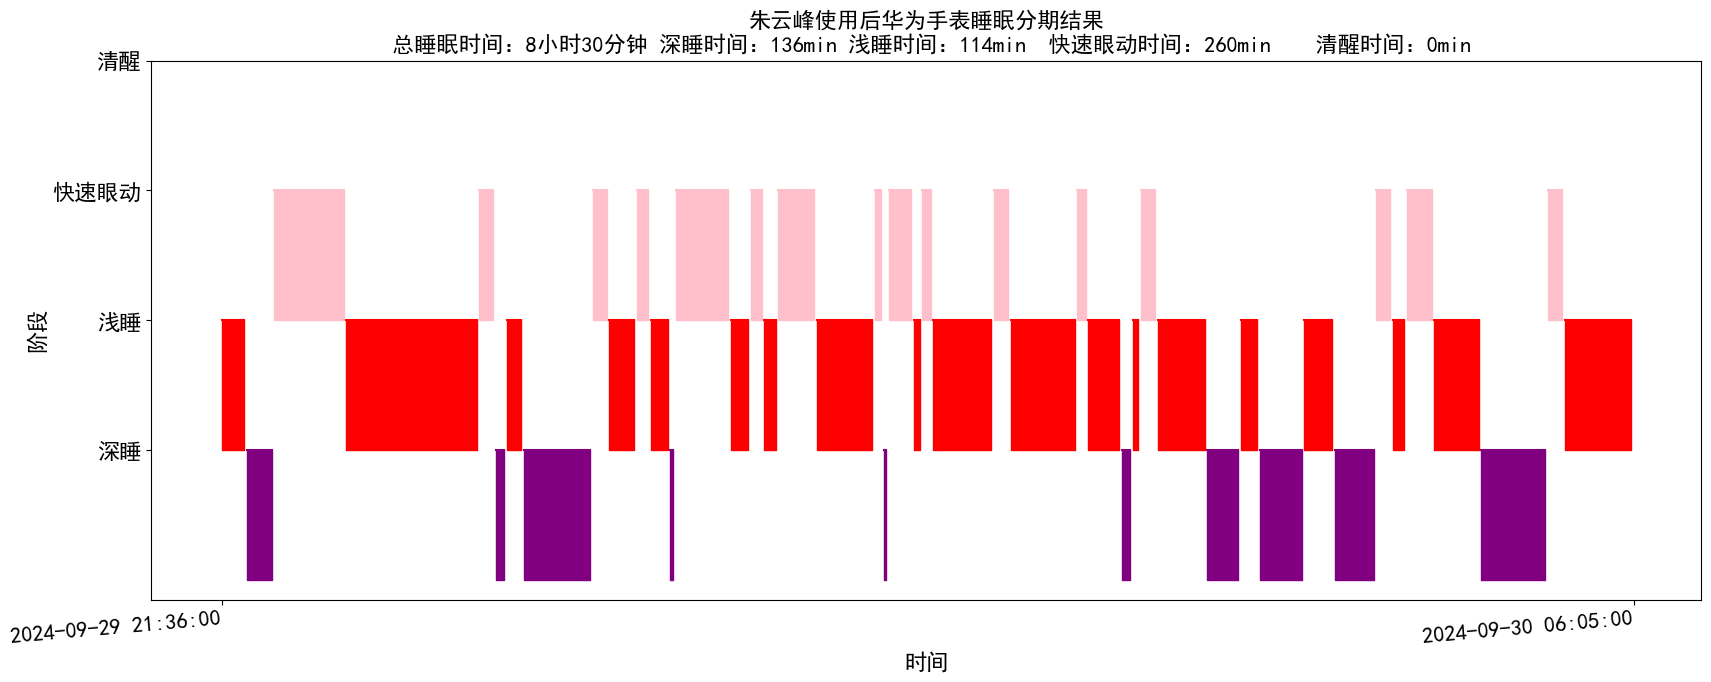

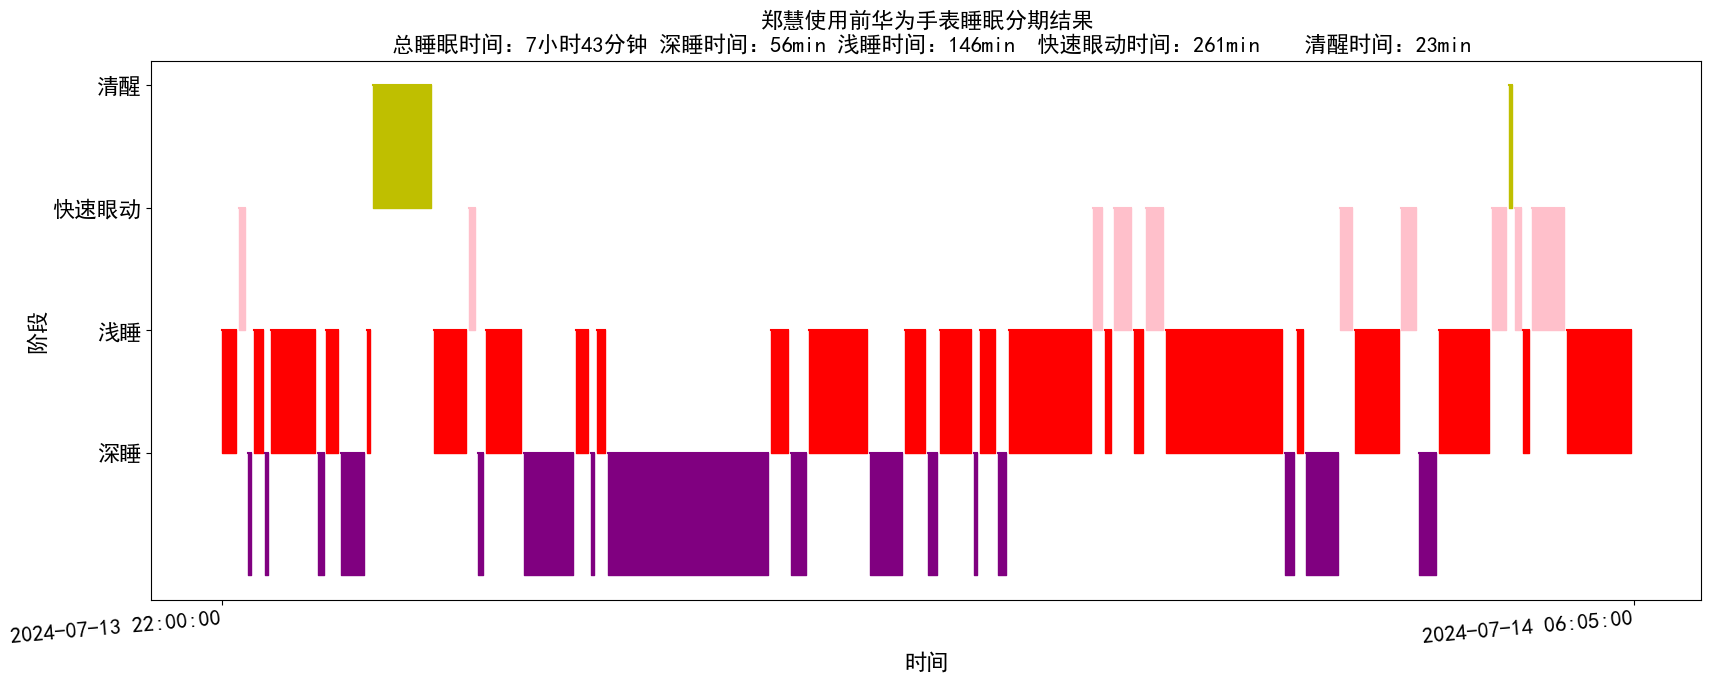

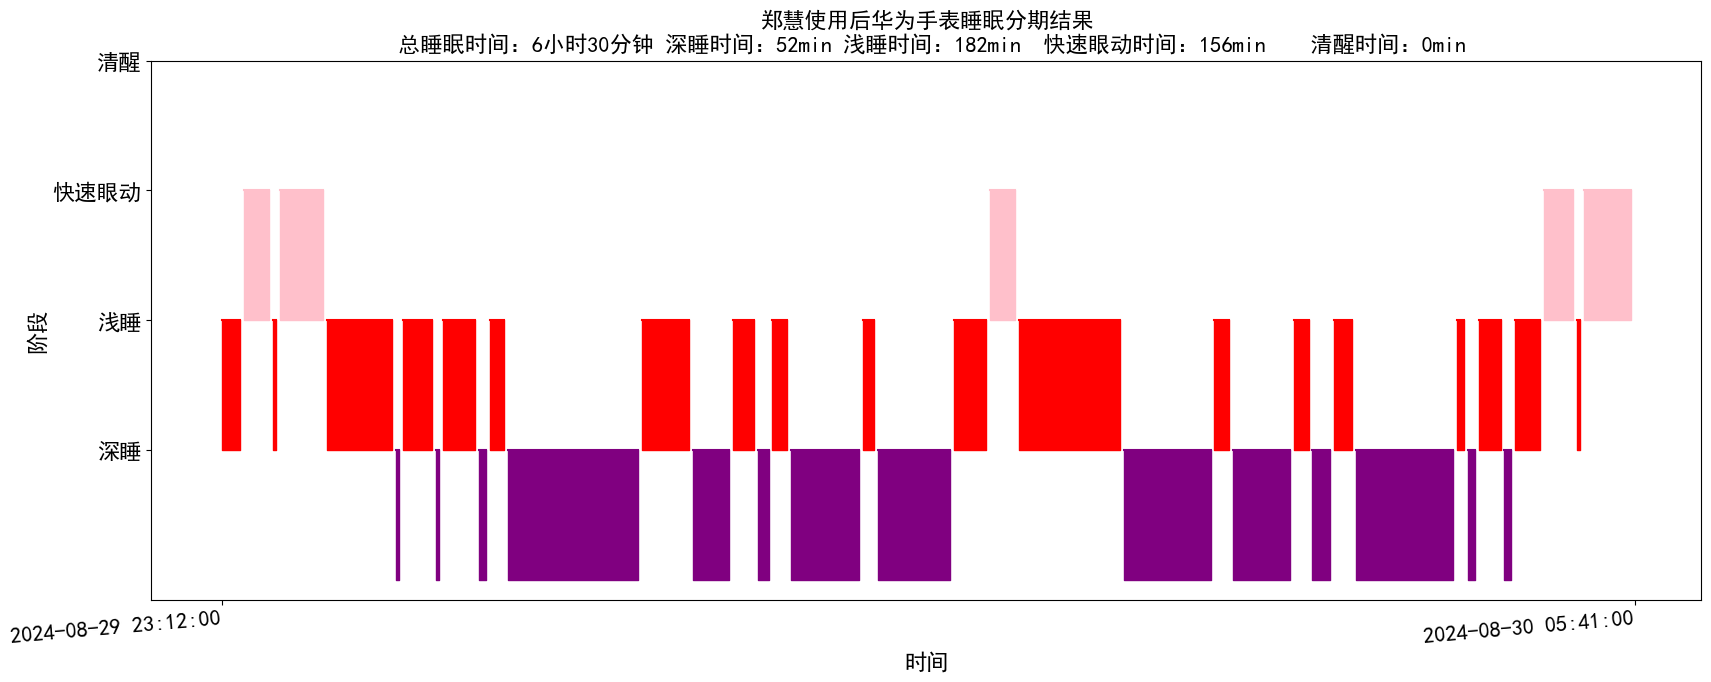

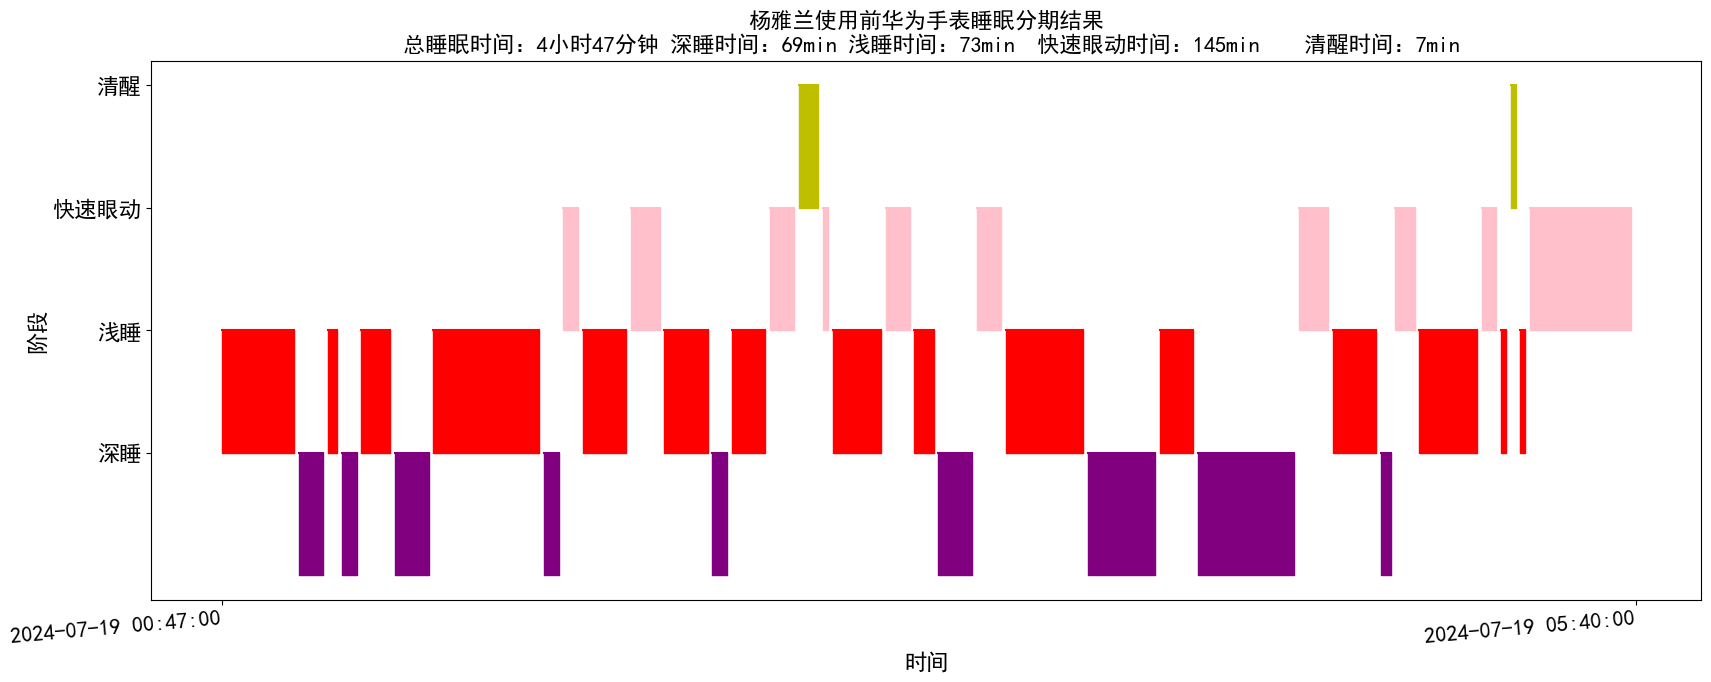

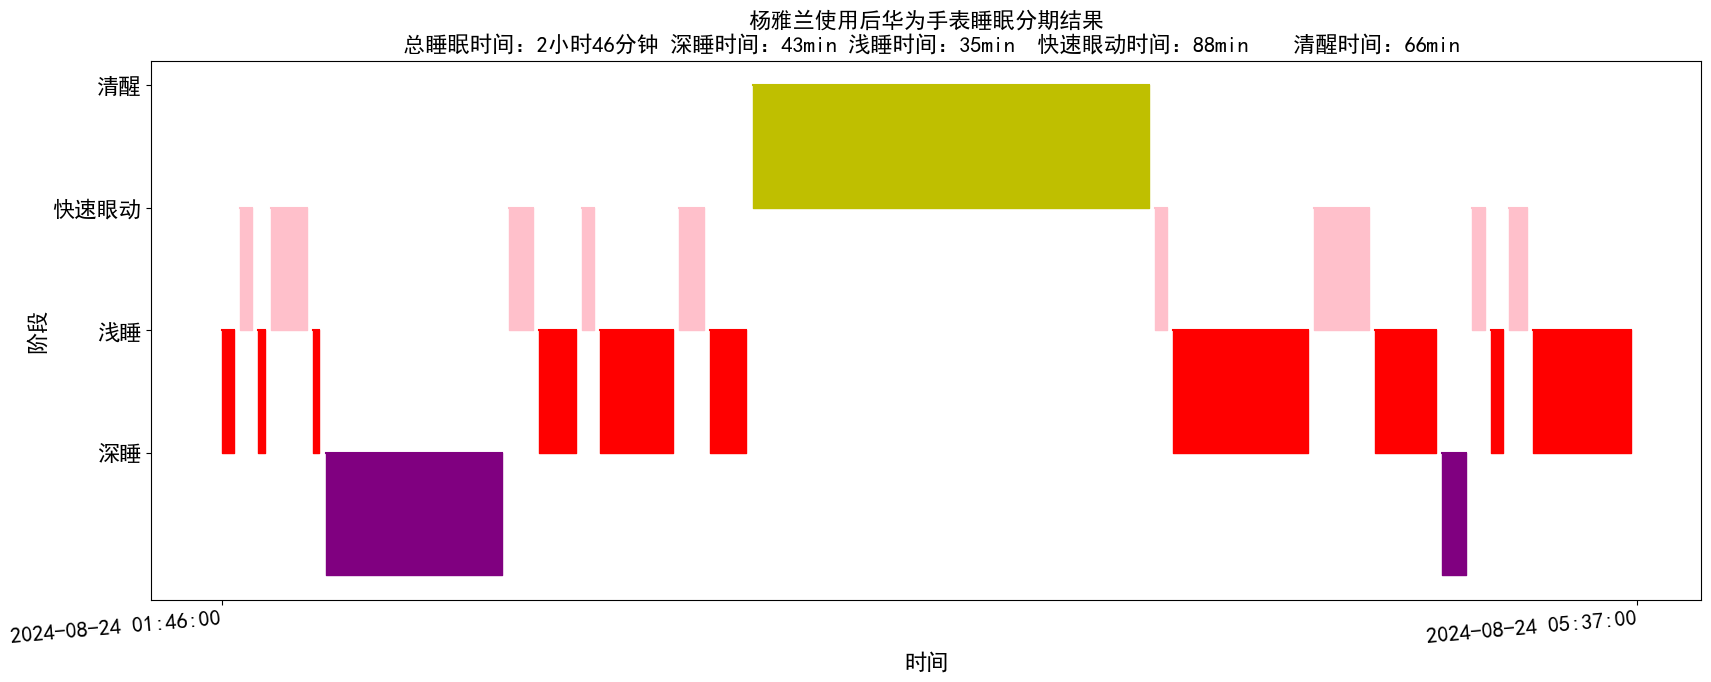

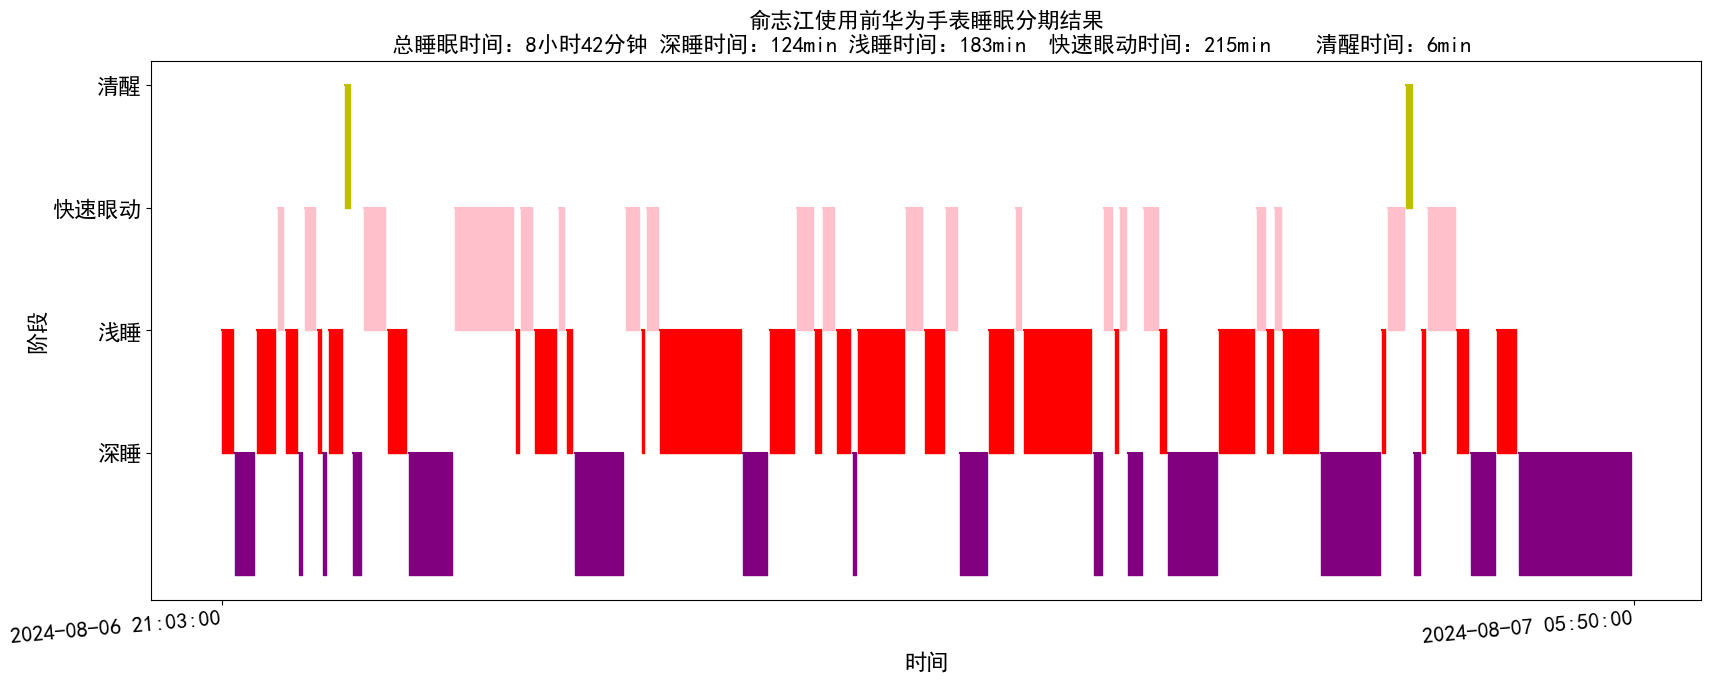

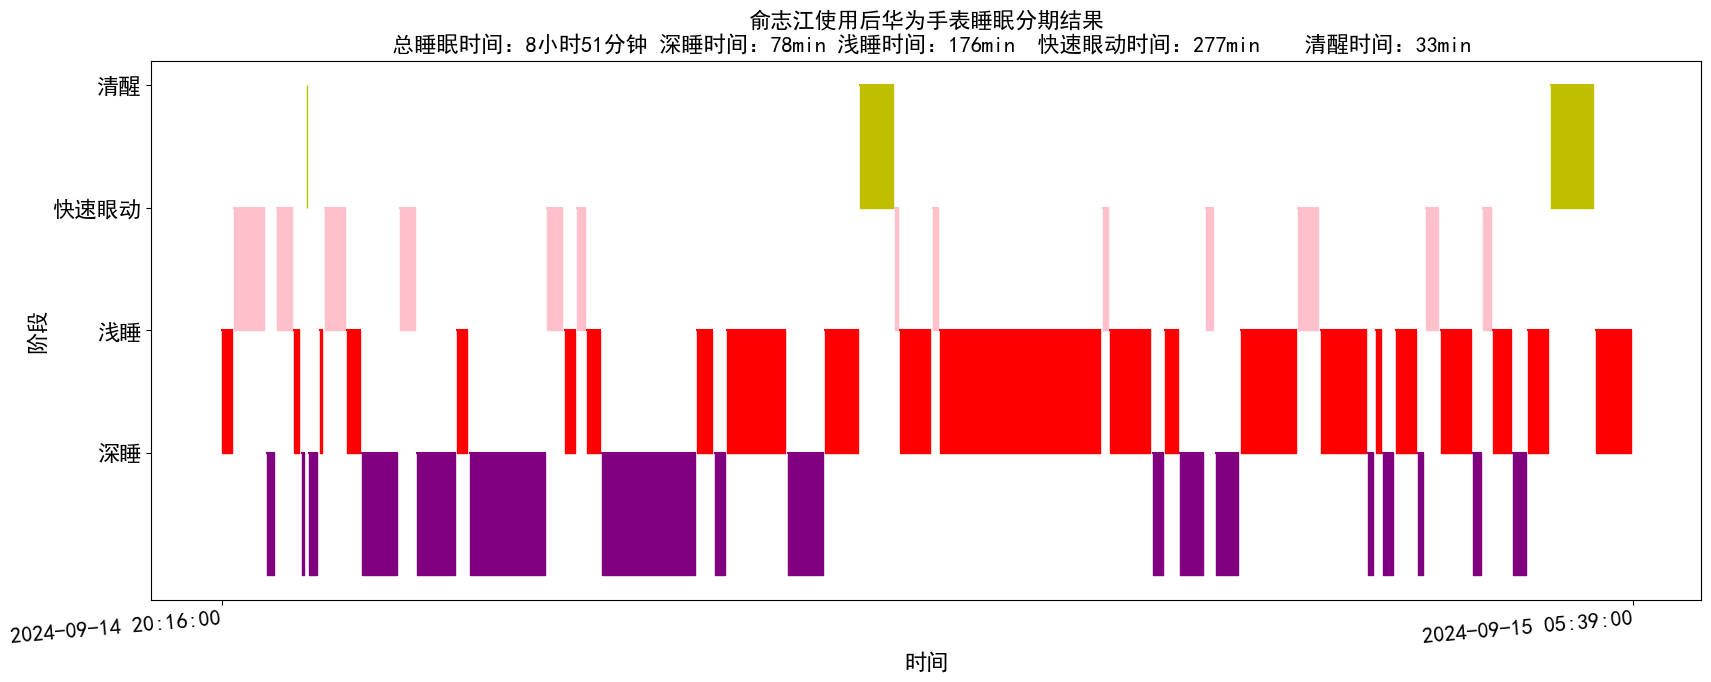

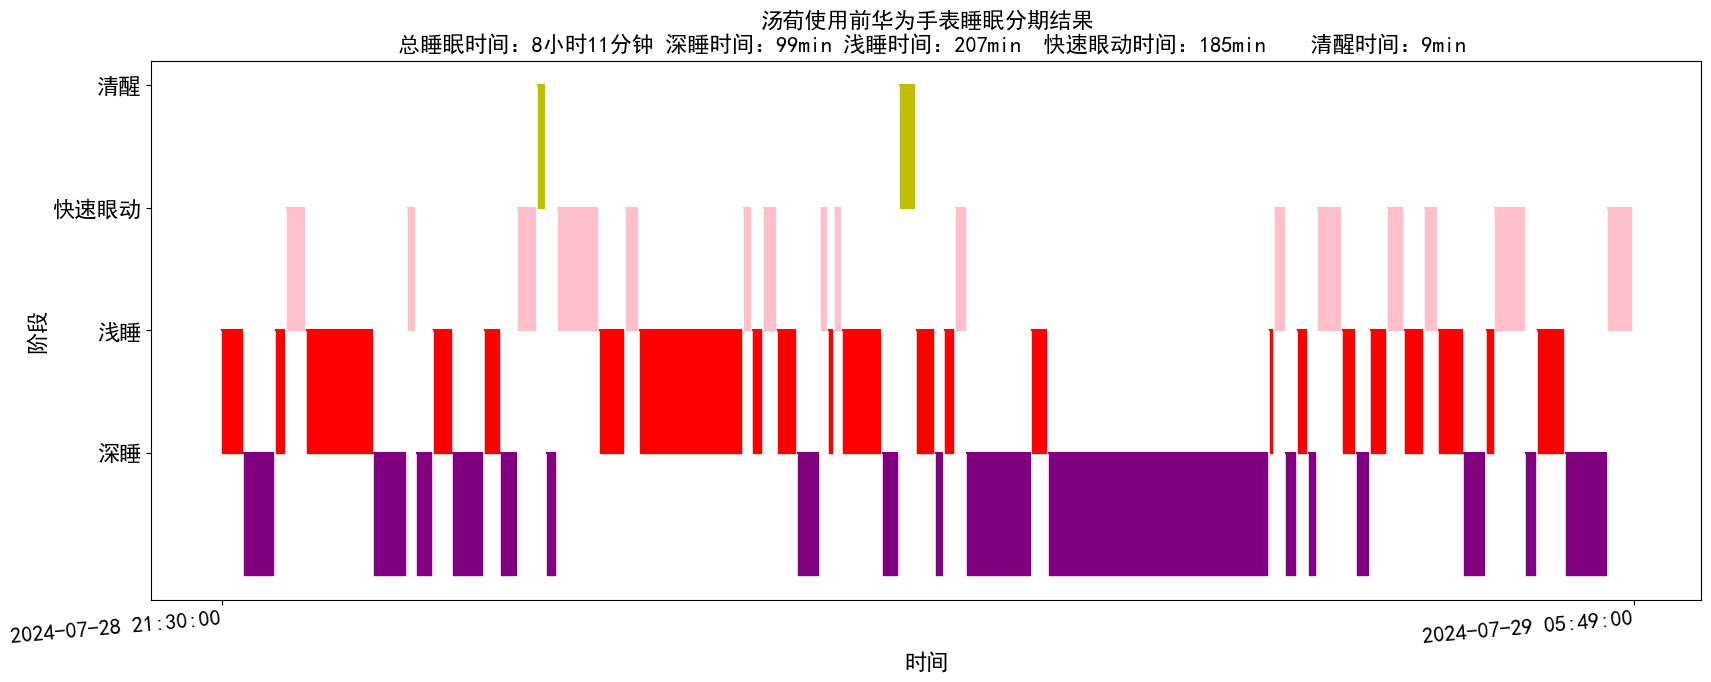

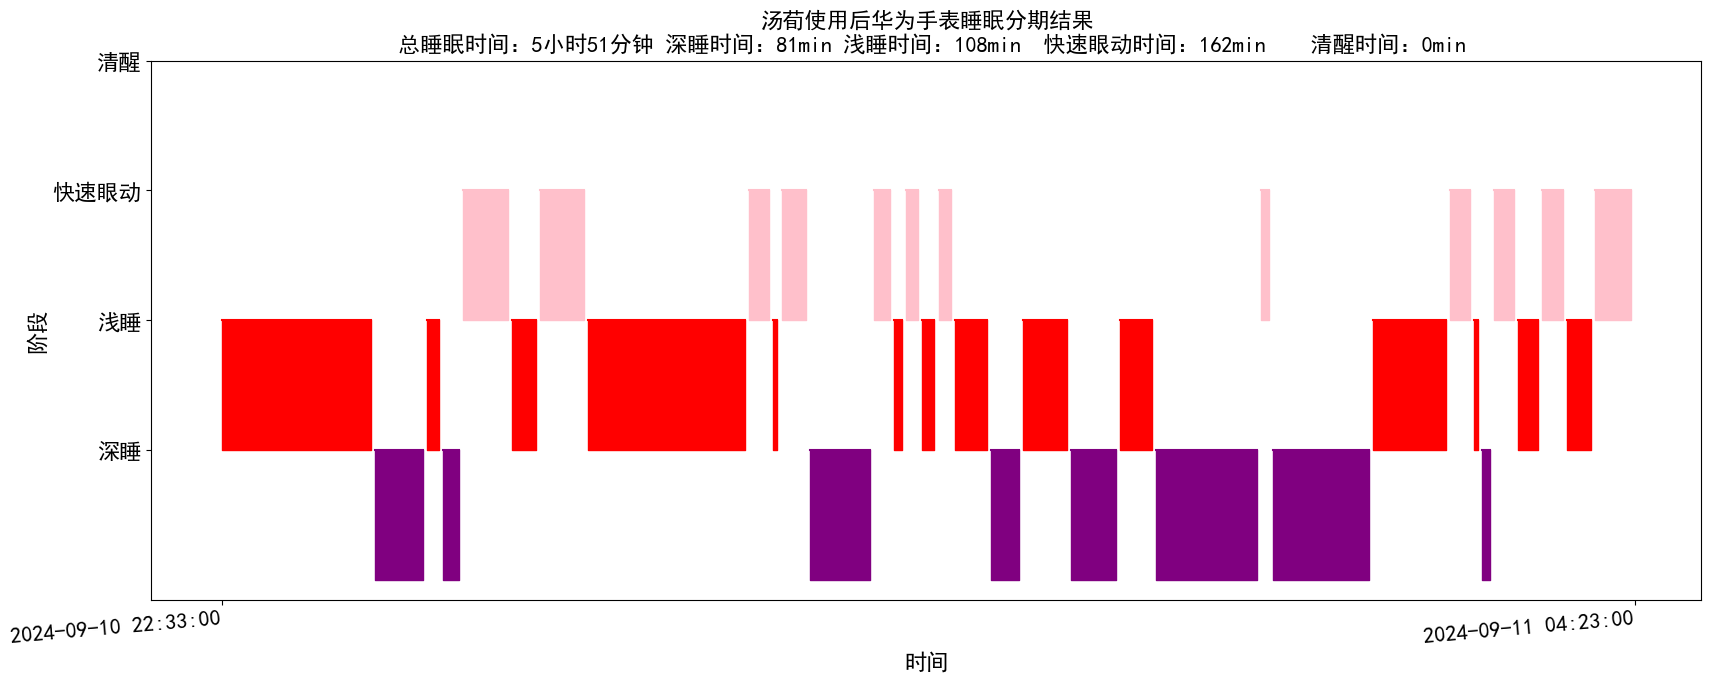

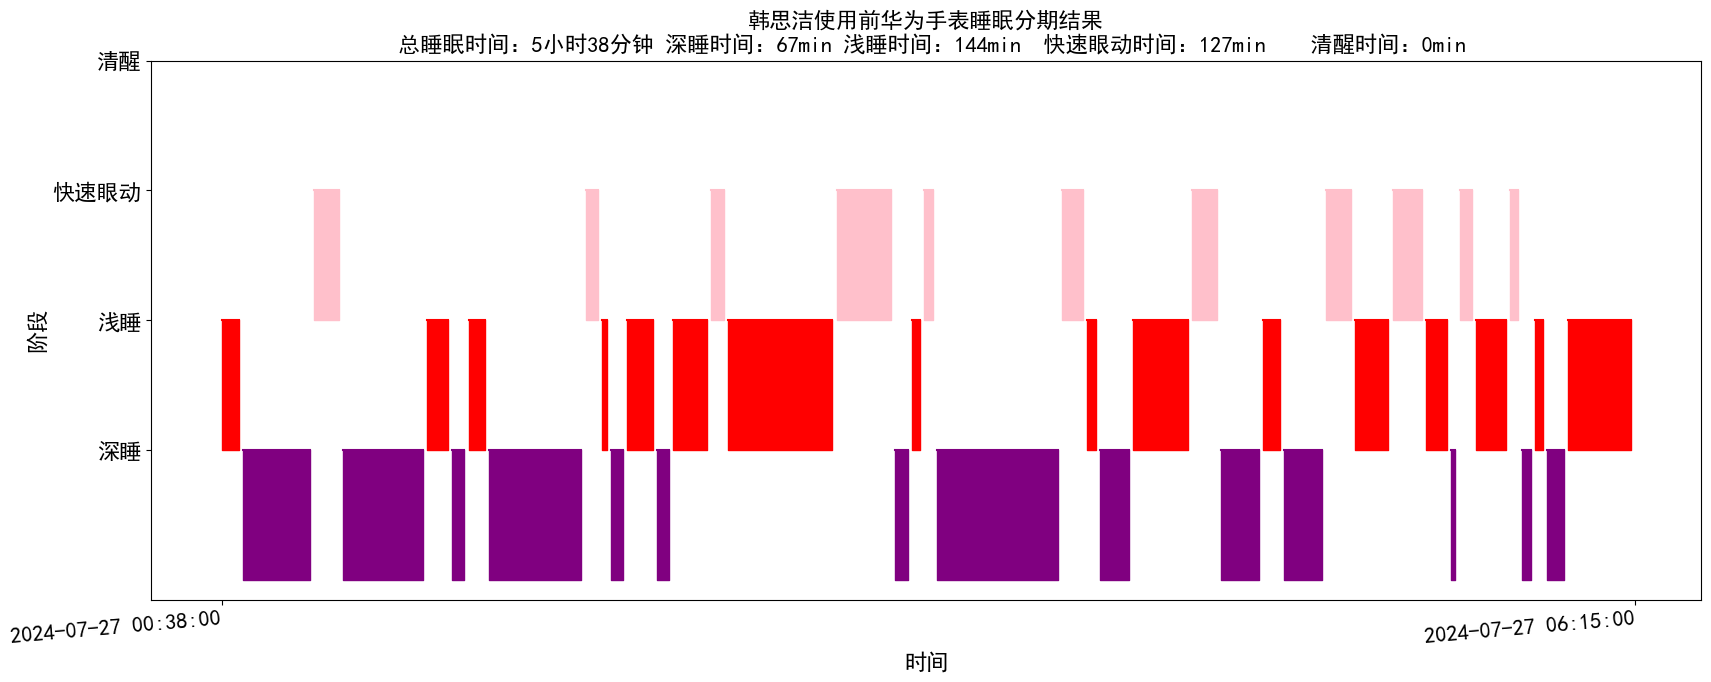

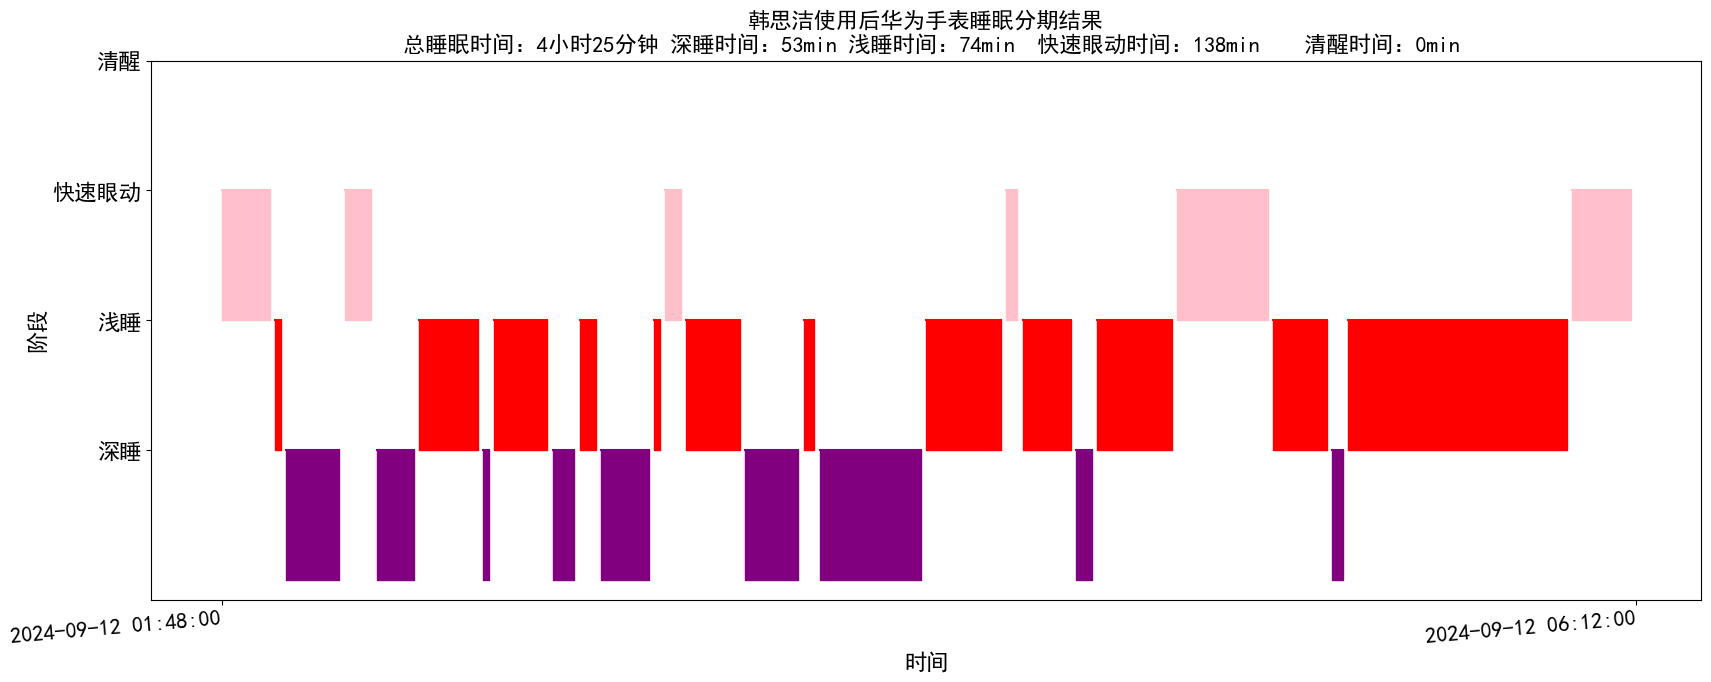

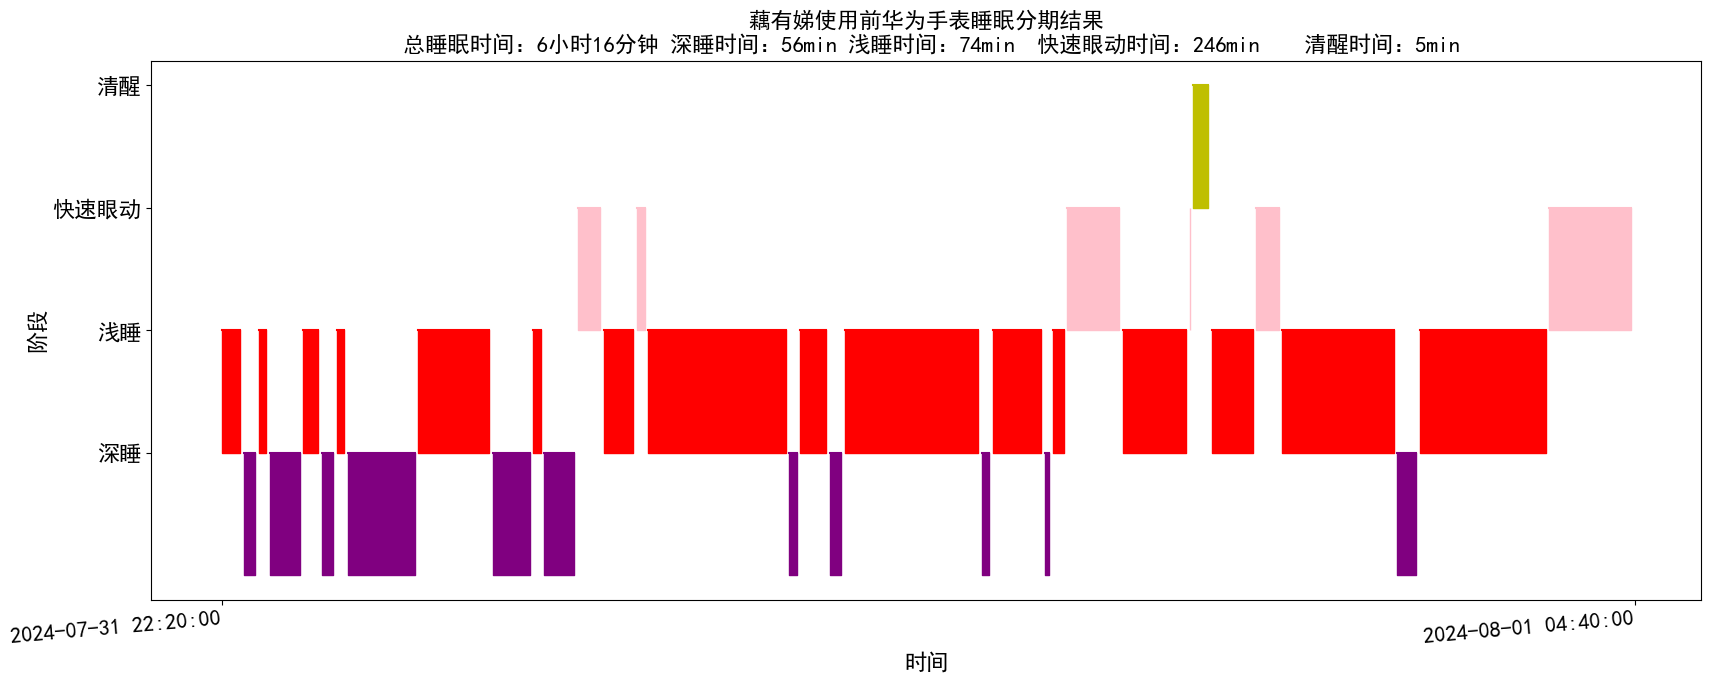

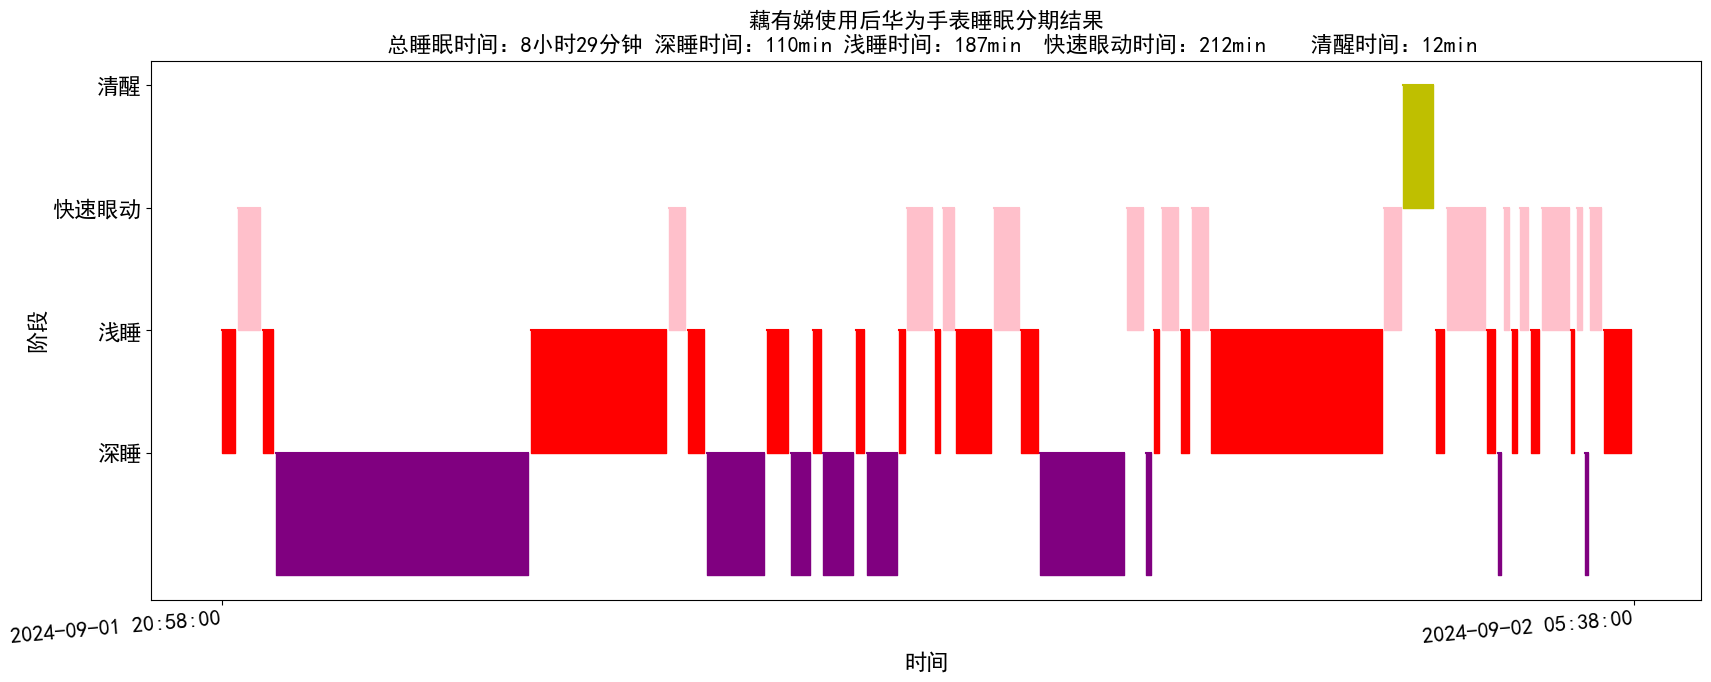

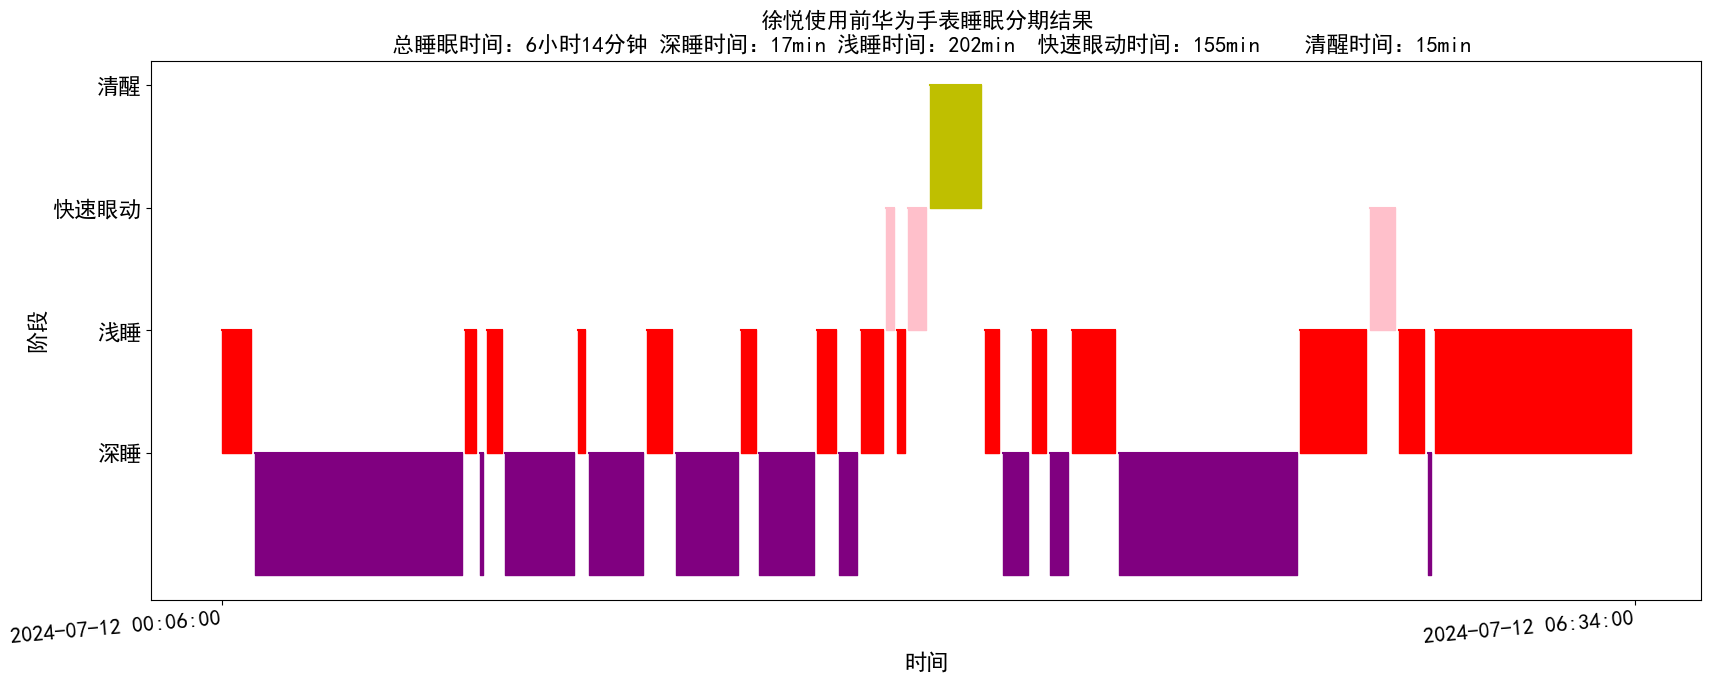

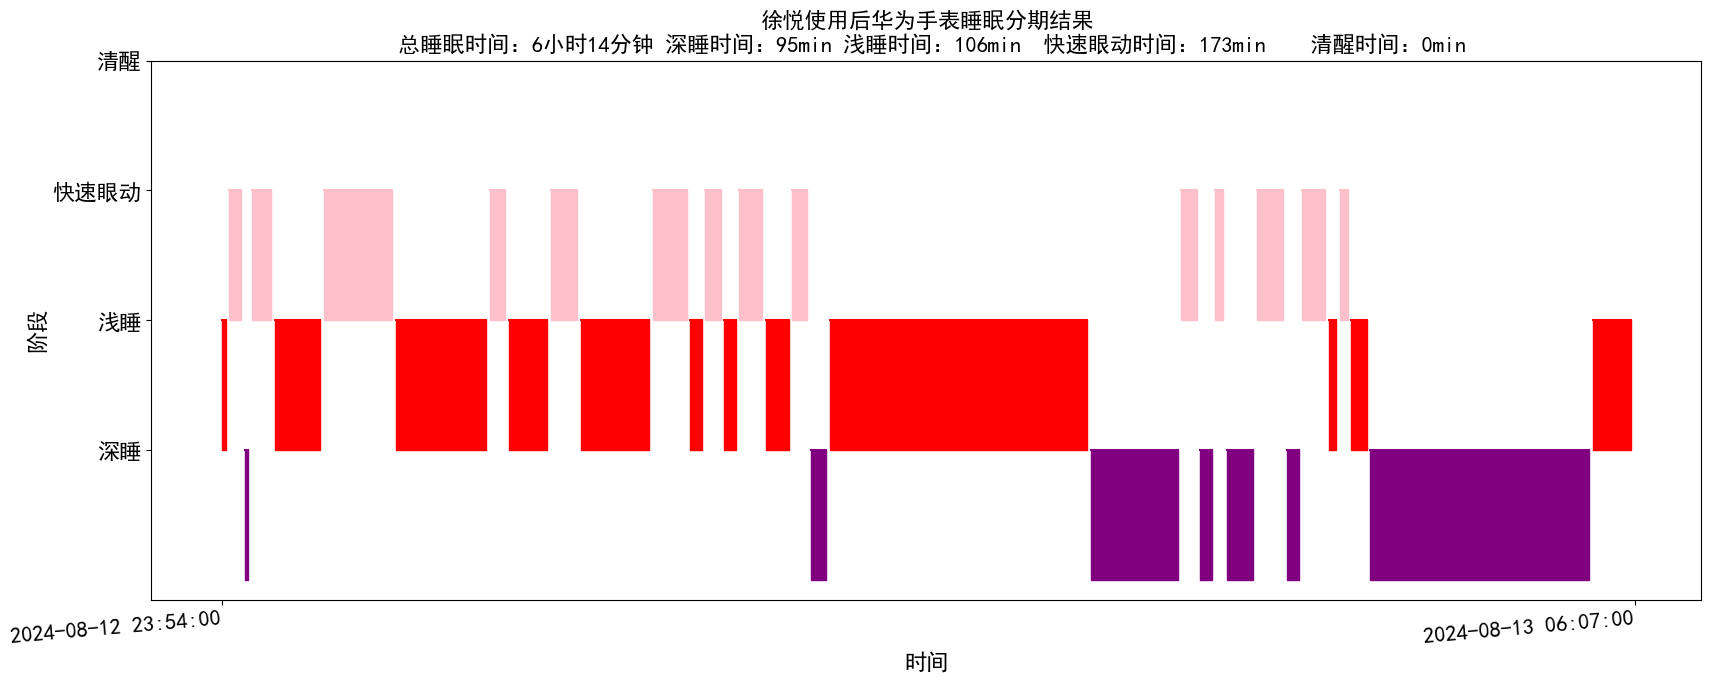

In [12]:
if __name__ == "__main__":
    
    path = "../data/第2晚已监测完"
    dir = os.listdir(path)
    for i in dir:
        name  = re.findall(r'[（](.*?)[）]',i)
        dir_path = os.path.join(path,i)
        before_path = os.path.join(dir_path,"Before_Use/Huawei_Watch_Data/Sleep_Staging.json")
        after_path = os.path.join(dir_path,"After_Use/Huawei_Watch_Data/Sleep_Staging.json")
        main(before_path,figpath=f"../result/huawei_result/before/{name[0]}使用前.png")
        main(after_path,figpath=f"../result/huawei_result/after/{name[0]}使用后.png")
